# Code

In [1]:
import pyRootPwa
import os

import numpy as np
#import scipy.stats
import scipy
import matplotlib.pyplot as plt
import math
import mle

import progressbar
import logging
logging.basicConfig(filename='/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/CompareIntegraleWithVarianz1.log',level=logging.INFO, format='%(levelname)s:%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

Welcome to JupyROOT 6.14/04


In [2]:
dir = '/nfs/freenas/tuph/e18/project/compass/analysis/tkumschier/ROOTPWA/test/TEST_FOLDER_RUNS2'
nmbFolder = len([name for name in os.listdir(dir)])
print nmbFolder

101


In [3]:
allIntegralMatrixes = np.empty(nmbFolder, dtype=pyRootPwa.libRootPwaPy.ampIntegralMatrix)

for i in range(0,nmbFolder):
    psIntegralPath = dir + '/ROOTPWA_MC_TEST' + str(i) + '/ints/integral_binID-0_2.root'
    intFile = pyRootPwa.ROOT.TFile.Open(psIntegralPath, "READ")
    intMeta = pyRootPwa.core.ampIntegralMatrixMetadata.readIntegralFile(intFile)
    allIntegralMatrixes[i] = intMeta.getAmpIntegralMatrix() 

In [10]:
nmbWaves = allIntegralMatrixes[0].nmbWaves()
print nmbWaves

vecMatrix = np.empty((nmbWaves, nmbWaves), dtype=np.ndarray)
for waveIndexI in range(0,nmbWaves):
    for waveIndexJ in range(0,nmbWaves): #waveIndexI+1):
         vecMatrix[waveIndexI][waveIndexJ] = np.empty(nmbFolder, dtype=complex) 

for i in range(0,nmbFolder):
    for waveIndexI in range(0,nmbWaves):
        for waveIndexJ in range(0,nmbWaves): #waveIndexI+1):
            vecMatrix[waveIndexI][waveIndexJ][i] = allIntegralMatrixes[i].element(waveIndexI, waveIndexJ)

95


In [9]:
#vecMatrix = np.load('CompareIntegraleWithVarianzResult_50k_Daten_1.npy')

In [11]:
#np.save('CompareIntegraleWithVarianzResult_50k_Daten_2.npy',vecMatrix)

## Fit
<https://stackoverflow.com/questions/35690937/errors-on-a-gaussian-histogram-curve-fit-using-scipy-curve-fit>  
<https://stackoverflow.com/questions/35544233/fit-a-curve-to-a-histogram-in-python>  
[Chi_Squared - Goodness of fit](https://en.wikipedia.org/wiki/Goodness_of_fit#Pearson's_chi-squared_test)  
[Chi_Squared](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)  
[Reduced_Chi_Squared](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic#Definition)   

In [5]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - 0.5 * ((x - mean) / standard_deviation) ** 2)

In [6]:
def chiSquared(n, bins, f, popt):
    f_exp = []
    for i in range(0,len(n)):
        f_exp.append(f(bins[i], *popt))
        #print i, n[i],  f_exp[i]
    c , p = scipy.stats.chisquare(np.array(n, dtype=np.float32), np.array(f_exp, dtype=np.float32))
    return c, p

In [7]:
# https://github.com/ibab/python-mle
def calcMLE(xs, ys, meanEstimated, amplitudeEstimated, standardDeviationEstimated):
    
    # Define model
    xMLE = mle.var('xMLE', observed=True, vector=True)
    yMLE = mle.var('yMLE', observed=True, vector=True)
    
    mean = mle.var('mean')
    amplitude = mle.var('amplitude')
    standardDeviation = mle.var('standardDeviation')
    sigma = mle.var('sigma')
    
    model = mle.Normal(yMLE,gaussian(xMLE, mean, amplitude, standardDeviation), sigma)

    # Fit model to data
    result = model.fit({'xMLE': xs, 'yMLE': ys}, {'mean': meanEstimated, 'amplitude':amplitudeEstimated, 'standardDeviation': standardDeviationEstimated, 'sigma': 1}, dispMsg=False)
    return result

In [8]:
def createPlot(matrix, xlabel, nmbFolder, plt, plot = False, waveIndexI = 0, waveIndexJ = 0, errorMsg = ""):
    chiSquaredGauss = (1,1)
    chiSquaredMLE = (1,1)
    popt = (float("nan"), float("nan"), float("nan"))
    nbins = int(math.sqrt(nmbFolder)) * 2
    n, bins = np.histogram(matrix, bins=nbins) # n = number of events per bin
    mean = np.mean(matrix)
    standardDeviation = np.std(matrix)
    var = np.var(matrix)
    amplitude = np.max(n)
    
    print(' Calc Values (np):  [mean, amp, standardDeviation] = %.8f, %.8f, %.8f' % (mean, amplitude, standardDeviation))

    
    # Generate data from bins as a set of points 
    bin_size = abs(bins[1]-bins[0])
    x = np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0, num=nbins,endpoint=True)
    y = n
    y[y==0]= 1e-8
    x_fit = np.linspace(x[0], x[-1], nbins)

    # Gaussian
    try:
        p0 = scipy.array([mean, amplitude, standardDeviation])
        popt, pcov = scipy.optimize.curve_fit(gaussian,x,y,p0) 
        print(' Curve fit (Gauss): [mean, amp, standardDeviation] = %.8f, %.8f, %.8f' %(popt[0], popt[1], popt[2]))
        chiSquaredGauss = chiSquared(n, bins, gaussian, popt)
        #print ' Chi-Squared (Gauss):', chiSquaredGauss
        
        if plot:
            y_gauss = gaussian(x_fit, *popt)
            plt.plot(x_fit, y_gauss,linestyle='--',linewidth=2, color='red',label='Gaussian')
    except:
        logging.warning('Error to calc Gaussian')
        print 'Error to calc Gaussian'
        errorMsg = "%s\n%i, %i: Error to calc Gaussian" %(errorMsg, waveIndexI, waveIndexJ)

    
    # Maximum Likelyhood Estimate
    try:
        poptMLE = calcMLE(x, y, mean, amplitude, standardDeviation)
        print(' Curve fit (MLE):   [mean, amp, standardDeviation] = %.8f, %.8f, %.8f' % (poptMLE.x['mean'], poptMLE.x['amplitude'], poptMLE.x['standardDeviation']))
        #print poptMLE.x['standardDeviation']
        chiSquaredMLE = chiSquared(n, bins, gaussian, popt)
        #print ' Chi-Squared (MLE):', chiSquaredMLE
        '''
        if poptMLE['success'] == False:
            print "Error to calc MLE -1-"
            raise ValueError("Error to calc MLE -1-")
        '''
        # Plot the fit
        if plot:
            yMLE = gaussian(x_fit,poptMLE.x['mean'], poptMLE.x['amplitude'], math.fabs(poptMLE.x['standardDeviation']))
            plt.plot(x_fit, yMLE,linestyle=':',linewidth=2, color='black',label='MLE')
    except:
        logging.warning('Error to calc MLE')
        print 'Error to calc MLE'
        errorMsg = "%s\n%i, %i: Error to calc MLE" %(errorMsg, waveIndexI, waveIndexJ)

    
    if plot:
        plt.bar(bins[:-1], n, width = bin_size)

        axes = plt.gca()
        axes.set_ylim([0,max(n)+1])
        plt.xlabel(xlabel)
        plt.ylabel("Number of events")
    return ([mean, amplitude, standardDeviation], chiSquaredGauss, chiSquaredMLE, popt, poptMLE, errorMsg)

## Beachte
in Zeile 7 + 8 muss die drei auf 0 gewechselt werden
Graph 4 4 hat ein Problem mit popt berechnen

0 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.47371067, 15.00000000, 0.00366283
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.47361833, 9.73907811, 0.00388218
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.47361831, 9.73904663, 0.00388220


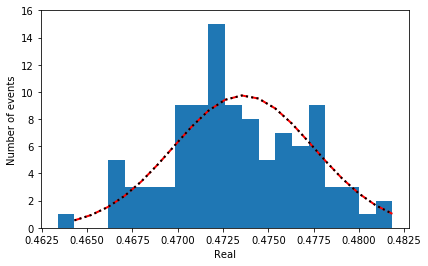

1 0
 Calc Values (np):  [mean, amp, standardDeviation] = 1.18190785, 13.00000000, 0.00905244
 Curve fit (Gauss): [mean, amp, standardDeviation] = 1.18187088, 9.68759755, 0.00984877
 Curve fit (MLE):   [mean, amp, standardDeviation] = 1.18187086, 9.68756265, 0.00984884
 Calc Values (np):  [mean, amp, standardDeviation] = -0.27199664, 13.00000000, 0.00212941
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.27167728, 10.11382551, 0.00208669
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.27167726, 10.11387411, 0.00208667


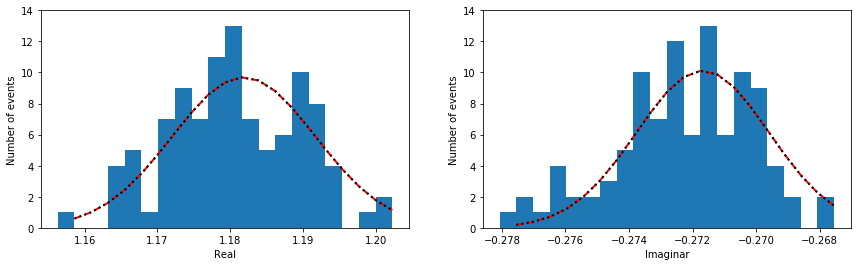

2 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00219229, 11.00000000, 0.00058525
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00216973, 8.81823229, 0.00062453
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00216973, 8.81823387, 0.00062453
 Calc Values (np):  [mean, amp, standardDeviation] = -0.06679838, 12.00000000, 0.00056826
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.06676786, 10.76034462, 0.00056746
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.06676786, 10.76034161, 0.00056746


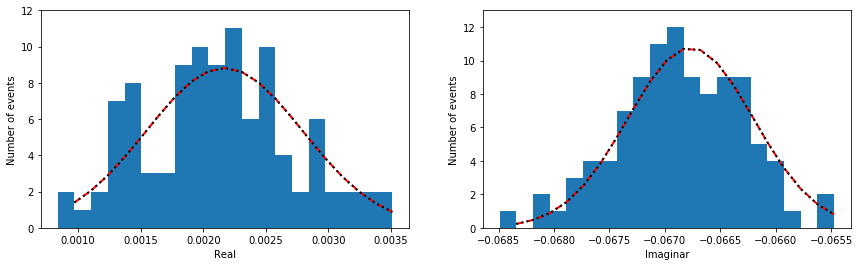

3 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.22529542, 15.00000000, 0.00176457
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.22524588, 9.74287683, 0.00182407
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.22524587, 9.74288920, -0.00182407
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00298153, 15.00000000, 0.00003790
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00298022, 11.23270067, 0.00003367
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00298022, 11.23285440, 0.00003367


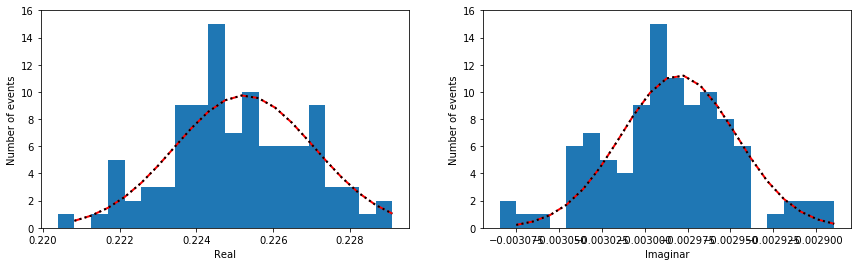

4 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.13365307, 12.00000000, 0.00787602
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.13354309, 10.62649011, 0.00819648
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.13354305, 10.62652831, 0.00819642
 Calc Values (np):  [mean, amp, standardDeviation] = 0.12392251, 13.00000000, 0.01018349
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.12577818, 11.44385574, 0.00858036
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.12577822, 11.44396613, 0.00858020


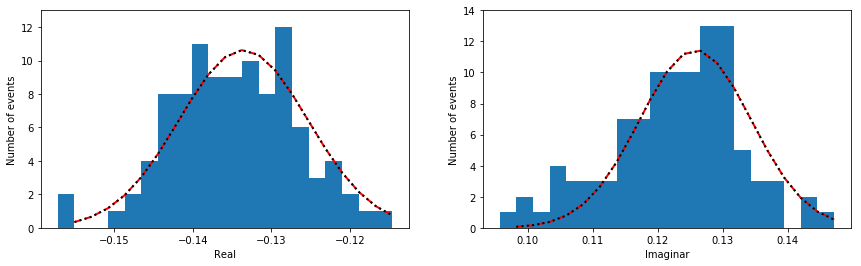

5 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.41251843, 12.00000000, 0.00265880
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.41255534, 9.13839952, 0.00278380
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.41255534, 9.13839558, 0.00278380
 Calc Values (np):  [mean, amp, standardDeviation] = -0.11708255, 13.00000000, 0.00267028
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.11709987, 9.40401662, 0.00304362
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.11709985, 9.40401371, 0.00304362


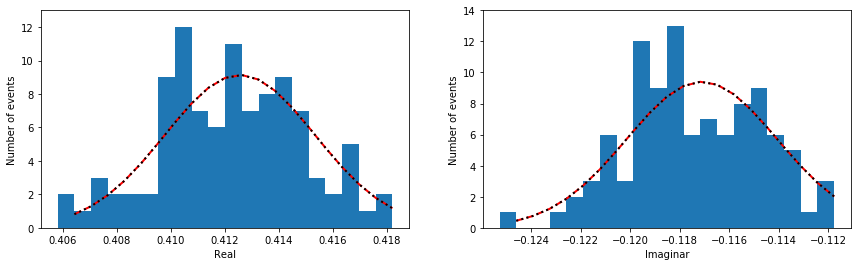

6 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00023597, 14.00000000, 0.00078197
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00012486, 11.52464571, 0.00068076
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00012485, 11.52472159, 0.00068075
 Calc Values (np):  [mean, amp, standardDeviation] = -0.03428182, 11.00000000, 0.00117976
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.03423513, 8.02038258, 0.00146450
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.03423513, 8.02036749, 0.00146450


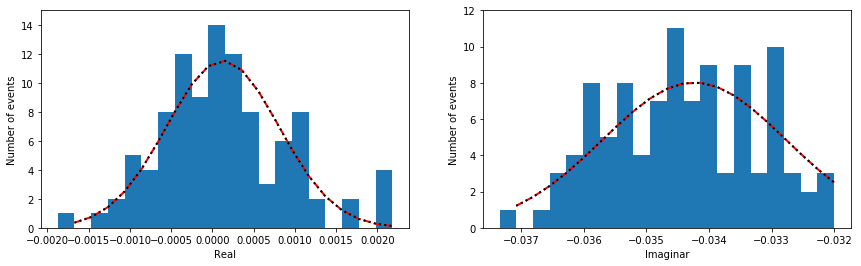

7 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00022998, 19.00000000, 0.00416024
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00006475, 14.26054306, 0.00383155
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00006475, 14.26052329, 0.00383156
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006805, 10.00000000, 0.00165669
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00028207, 9.14592205, 0.00175596
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00028208, 9.14598002, 0.00175594


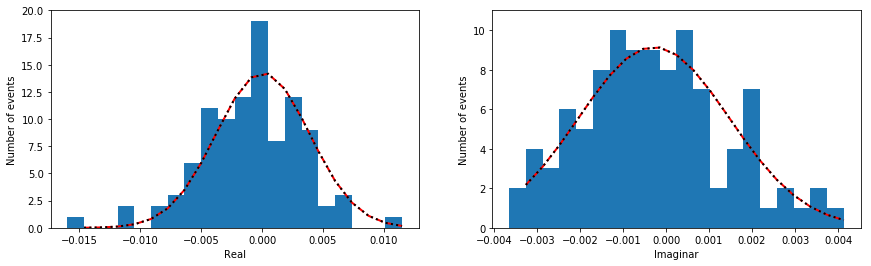

8 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00059467, 17.00000000, 0.00929946
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00007081, 15.16962831, 0.00812580
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00007081, 15.16964581, 0.00812578
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00041781, 15.00000000, 0.00470238
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00093035, 10.92149388, 0.00437833
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00093035, 10.92161152, 0.00437823


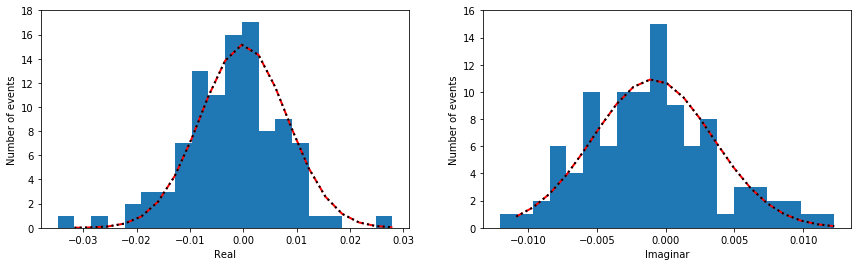

9 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00011350, 21.00000000, 0.00199175
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00004003, 14.24996073, 0.00183982
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00004003, 14.24995028, 0.00183982
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00004215, 12.00000000, 0.00079552
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00011433, 9.25245647, 0.00086605
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00011433, 9.25246827, 0.00086604


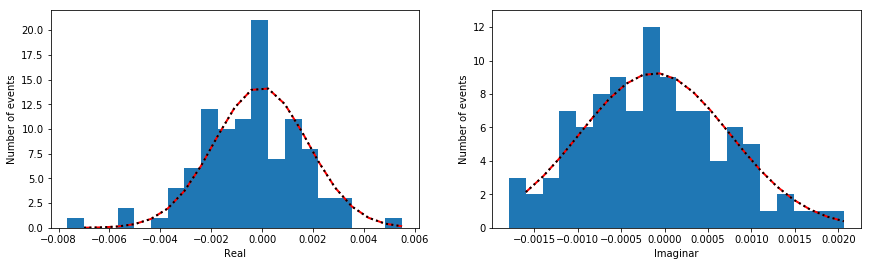

10 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00013532, 16.00000000, 0.00308663
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00042880, 9.20165408, 0.00333638
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00042880, 9.20169381, -0.00333635
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00030200, 11.00000000, 0.00383850
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00029103, 8.73964790, 0.00407238
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00029102, 8.73962341, 0.00407241


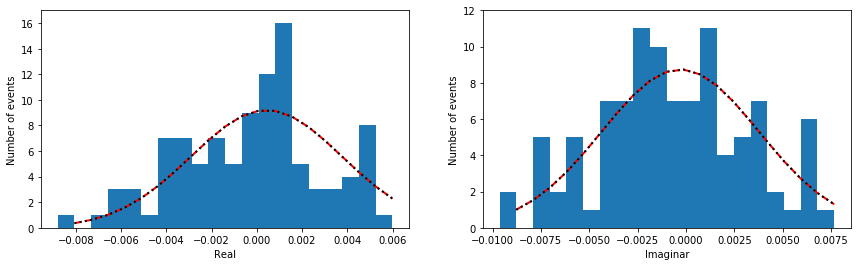

11 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006516, 14.00000000, 0.02160851
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00302923, 10.63604505, 0.02154147
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00302937, 10.63610627, 0.02154122
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00525616, 16.00000000, 0.02633845
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00431282, 12.10849747, 0.02434166
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00431280, 12.10854086, -0.02434149


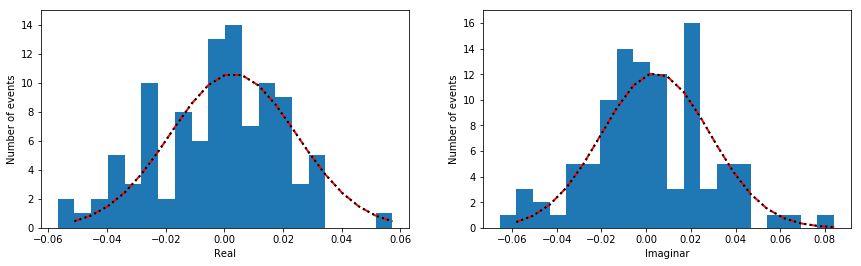

12 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00001871, 16.00000000, 0.00226014
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00030336, 12.17269942, 0.00222319
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00030336, 12.17271366, 0.00222319
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00018625, 14.00000000, 0.00203368
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00005714, 9.08553615, 0.00209171
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00005715, 9.08561022, 0.00209168


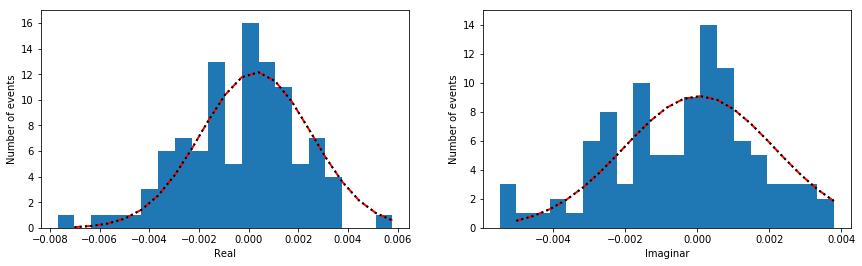

13 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00107282, 10.00000000, 0.00903660
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00133892, 8.04080823, 0.01074358
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00133894, 8.04079787, -0.01074361
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00072282, 12.00000000, 0.01000091
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00096107, 8.77193022, 0.01082773
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00096104, 8.77193042, 0.01082773


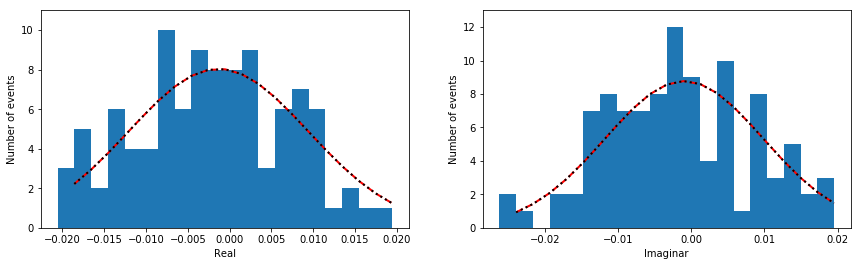

14 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00486002, 15.00000000, 0.08435503
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.01146957, 9.64361056, 0.08108840
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.01146936, 9.64371017, 0.08108670
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00655053, 13.00000000, 0.11309610
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00677408, 10.01749792, 0.10748620
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00677493, 10.01761080, 0.10748377


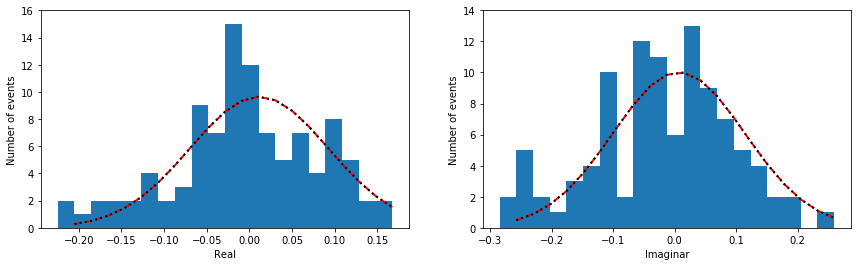

15 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00011280, 17.00000000, 0.00089143
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00002397, 13.03307669, 0.00067225
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00002396, 13.03341783, 0.00067221
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006594, 12.00000000, 0.00109698
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00002362, 10.65674916, 0.00117459
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00002362, 10.65675419, 0.00117459


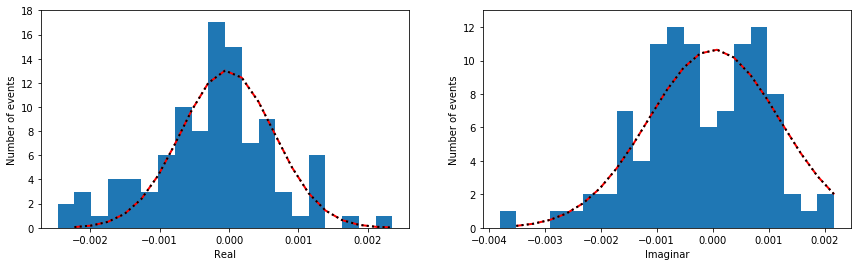

16 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00023448, 14.00000000, 0.00256539
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00017554, 11.91661270, 0.00231087
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00017554, 11.91662606, 0.00231086
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00020008, 13.00000000, 0.00362938
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00042998, 9.03589389, 0.00374216
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00043000, 9.03590181, 0.00374216


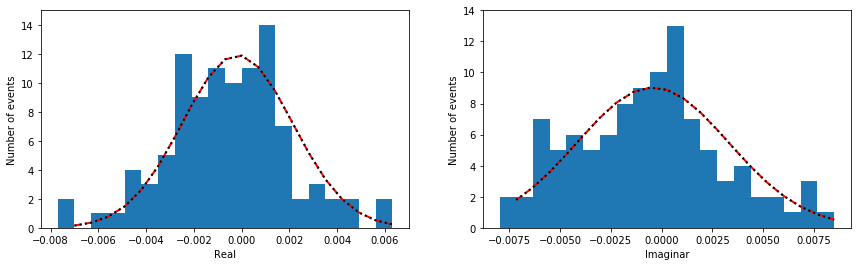

17 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00075397, 15.00000000, 0.00443545
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00121237, 12.52778634, 0.00362500
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00121240, 12.52794551, 0.00362491
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006935, 14.00000000, 0.00145202
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00011716, 10.34225811, 0.00141021
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00011716, 10.34232828, 0.00141019


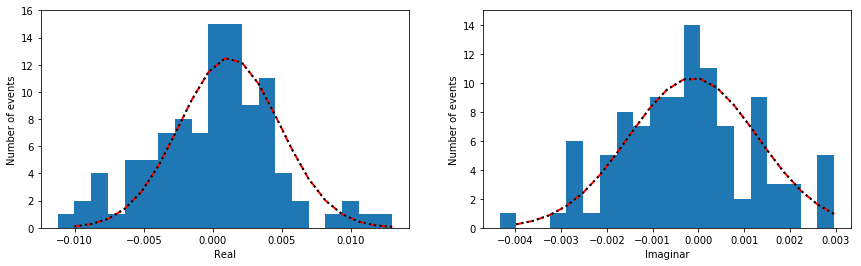

18 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00167442, 14.00000000, 0.01051807
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00176139, 11.84754217, 0.00993230
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00176141, 11.84757560, 0.00993224
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00052465, 10.00000000, 0.00407494
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00065308, 8.41967448, 0.00487837
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00065304, 8.41969857, 0.00487834


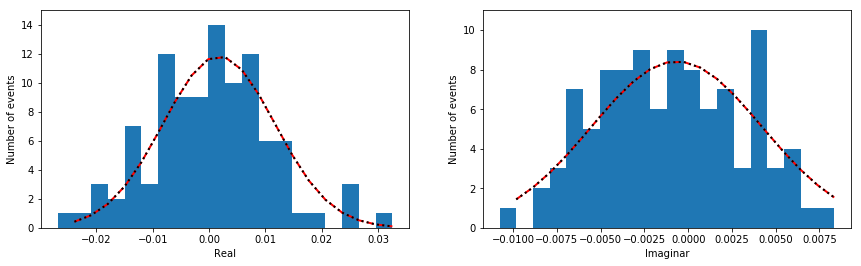

19 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00035071, 15.00000000, 0.00210447
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00055267, 12.58255335, 0.00172618
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00055268, 12.58270845, -0.00172614
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00003101, 13.00000000, 0.00069869
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00003047, 10.49650747, 0.00069015
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00003048, 10.49657142, 0.00069014


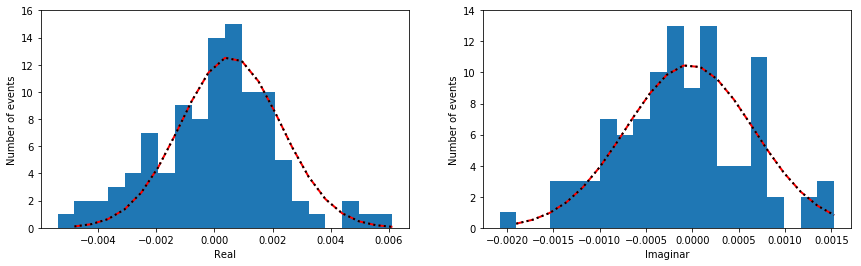

20 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00009760, 9.00000000, 0.00284178
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00041960, 7.45261785, 0.00376737
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00041961, 7.45259931, 0.00376740
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00032724, 12.00000000, 0.00368737
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00023386, 8.85110679, 0.00409623
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00023386, 8.85111478, 0.00409622


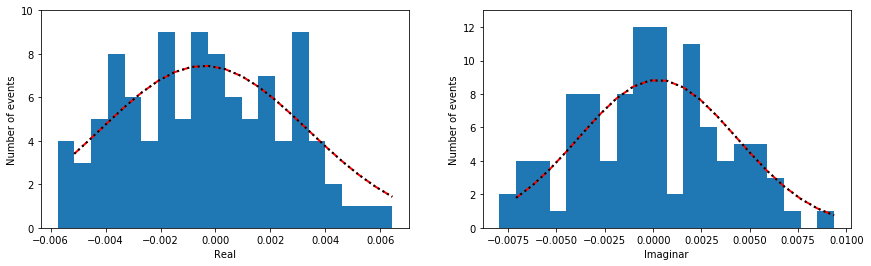

21 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00038149, 15.00000000, 0.00244295
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00011461, 9.66172293, 0.00252528
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00011460, 9.66177532, 0.00252525
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00046833, 12.00000000, 0.00192153
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00043092, 9.34372585, 0.00193239
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00043092, 9.34377728, 0.00193237


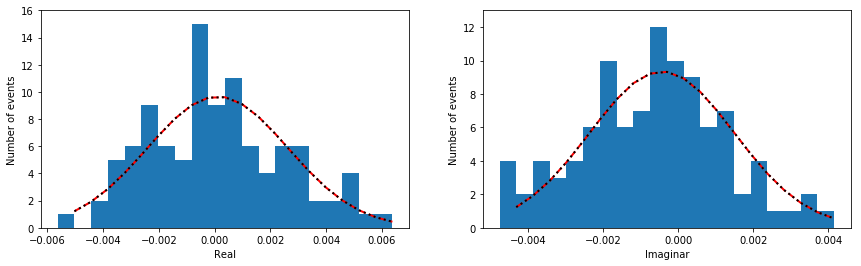

22 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00016056, 13.00000000, 0.00097347
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00012463, 10.80759575, 0.00089637
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00012463, 10.80775610, 0.00089635
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00011152, 13.00000000, 0.00117460
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00013644, 12.82765571, 0.00099234
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00013644, 12.82776160, 0.00099232


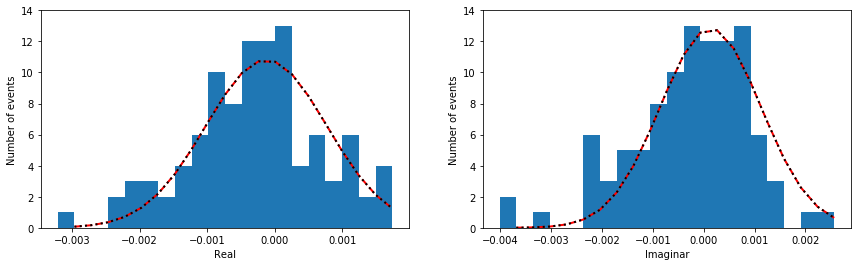

23 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00021311, 12.00000000, 0.00238424
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00002995, 11.18018269, 0.00247978
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00002994, 11.18010922, 0.00247981
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00000237, 15.00000000, 0.00319239
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00015899, 9.75204084, 0.00322707
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00015901, 9.75210408, 0.00322702


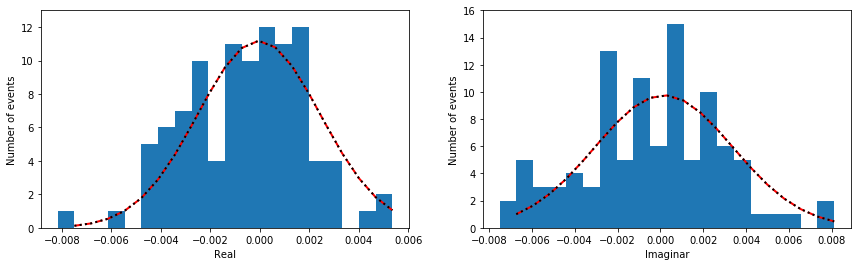

24 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00007172, 17.00000000, 0.00105702
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00007784, 11.34269702, 0.00103159
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00007784, 11.34274024, 0.00103159
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00015243, 13.00000000, 0.00083146
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00014658, 11.93006679, 0.00077980
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00014658, 11.93014515, 0.00077979


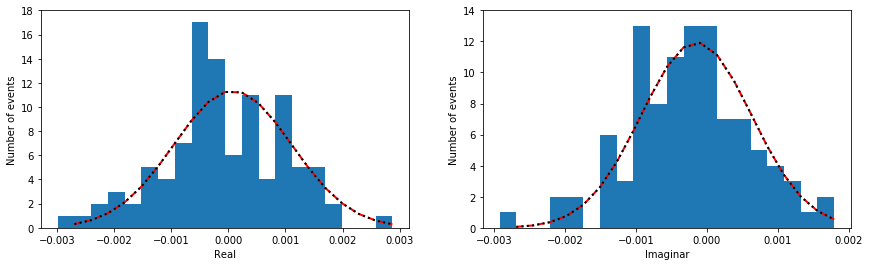

25 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006783, 15.00000000, 0.00107339
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00015664, 9.25214891, 0.00111471
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00015665, 9.25223467, -0.00111469
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00011922, 15.00000000, 0.00117662
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00020346, 11.92842071, 0.00101472
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00020347, 11.92847320, -0.00101471


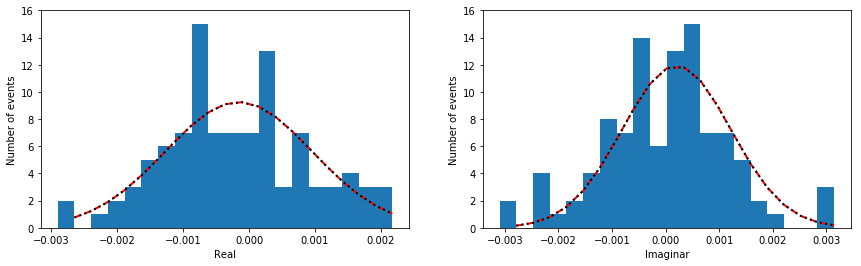

26 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00010391, 17.00000000, 0.00089509
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00017078, 10.03975262, 0.00084118
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00017078, 10.03988022, 0.00084116
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00008857, 17.00000000, 0.00100247
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00010509, 12.29574651, 0.00078109
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00010509, 12.29604160, 0.00078106


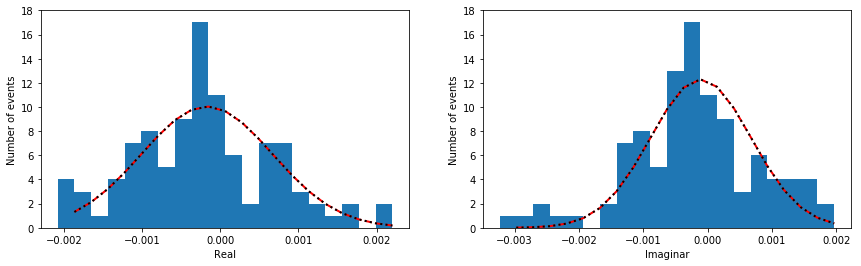

27 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00008735, 13.00000000, 0.00100872
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00006320, 10.40798176, 0.00094646
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00006320, 10.40812643, 0.00094644
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006006, 14.00000000, 0.00092950
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00007779, 11.85281489, 0.00091399
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00007779, 11.85281394, 0.00091399


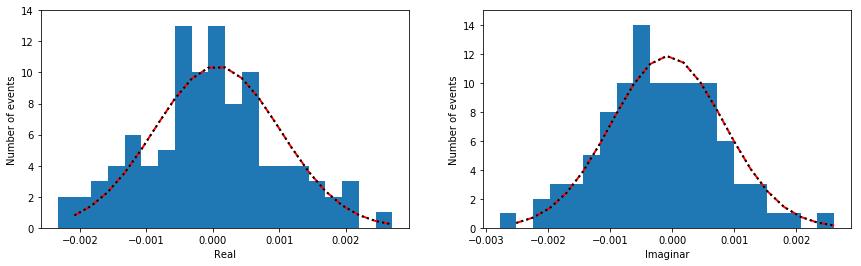

28 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00021592, 16.00000000, 0.00386408
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00000281, 10.93155074, 0.00410991
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00000280, 10.93151402, 0.00410994
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00001893, 15.00000000, 0.00412414
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00035539, 11.51260784, 0.00388811
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00035540, 11.51264285, 0.00388808


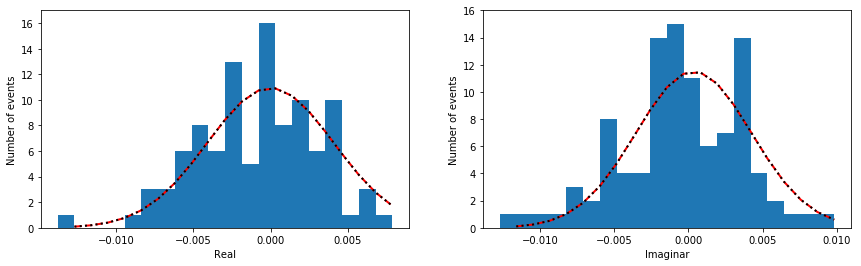

29 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00011585, 20.00000000, 0.00402100
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00047514, 16.33777725, 0.00315445
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00047516, 16.33788288, 0.00315441
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00002382, 15.00000000, 0.00340073
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00027858, 13.62035018, 0.00290141
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00027859, 13.62045782, 0.00290137


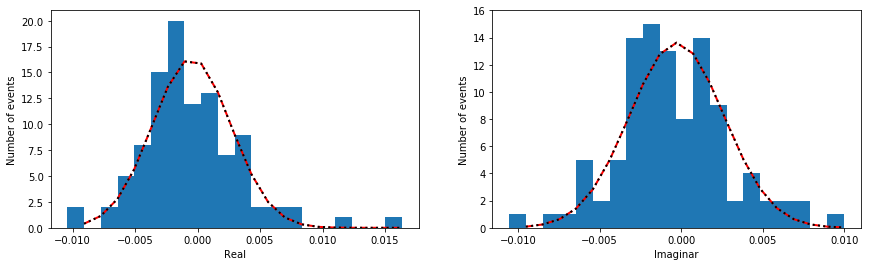

30 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00079789, 14.00000000, 0.00376325
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00093475, 8.93479065, 0.00410533
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00093475, 8.93479075, 0.00410533
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00004554, 11.00000000, 0.00431473
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00054099, 8.19013686, 0.00508698
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00054100, 8.19010090, 0.00508703


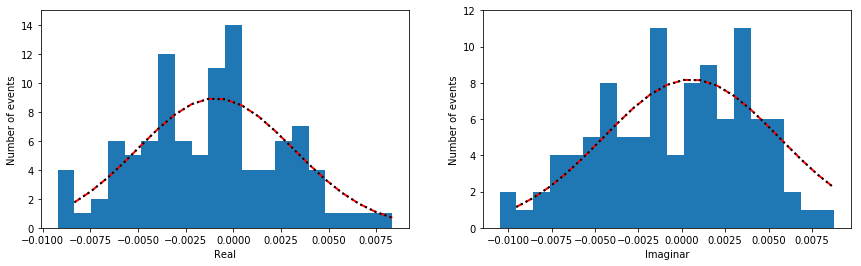

31 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00049074, 17.00000000, 0.00778006
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00064268, 9.64966428, 0.00827384
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00064267, 9.64967149, -0.00827382
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00035172, 17.00000000, 0.00780178
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00010894, 15.68980230, 0.00583020
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00010892, 15.68994570, 0.00583010


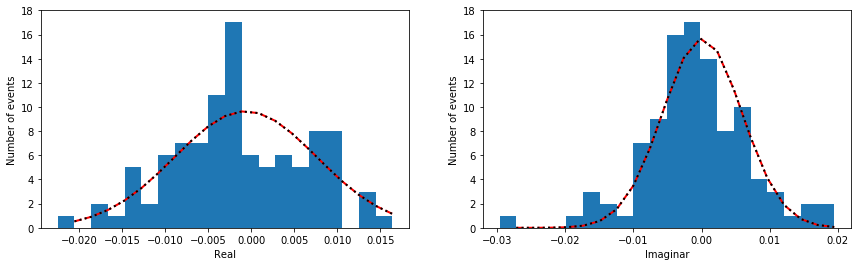

32 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00019211, 11.00000000, 0.00307171
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00009566, 8.66829117, 0.00306872
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00009566, 8.66832562, 0.00306869
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006895, 13.00000000, 0.00340455
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00087804, 9.74977774, 0.00405747
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00087806, 9.74976958, 0.00405748


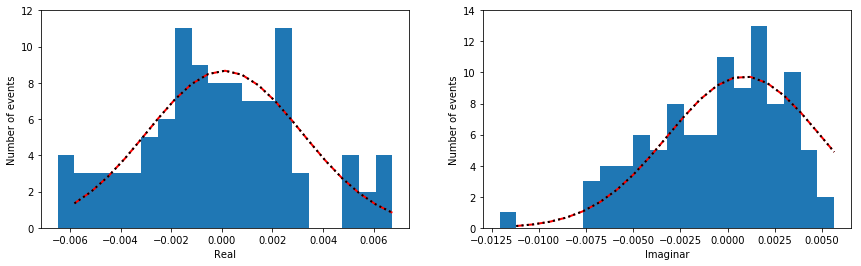

33 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00015231, 11.00000000, 0.00358156
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00007923, 7.04408568, 0.00449659
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00007923, 7.04406609, -0.00449662
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00039112, 14.00000000, 0.00360116
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00060802, 10.78008869, 0.00363358
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00060803, 10.78013583, 0.00363355


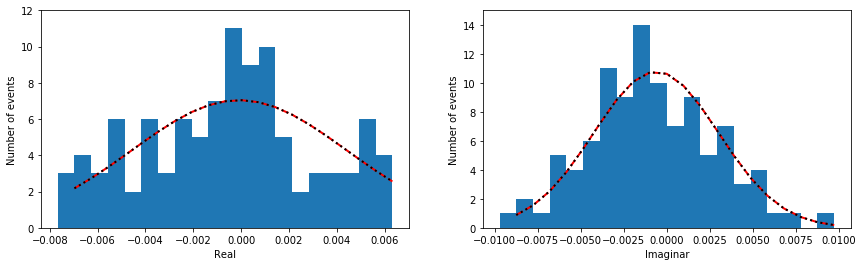

34 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00052746, 13.00000000, 0.00366518
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00071501, 9.32166867, 0.00401445
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00071501, 9.32165272, 0.00401446
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00037072, 16.00000000, 0.00425933
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00029988, 15.92482745, 0.00353355
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00029987, 15.92482421, 0.00353356


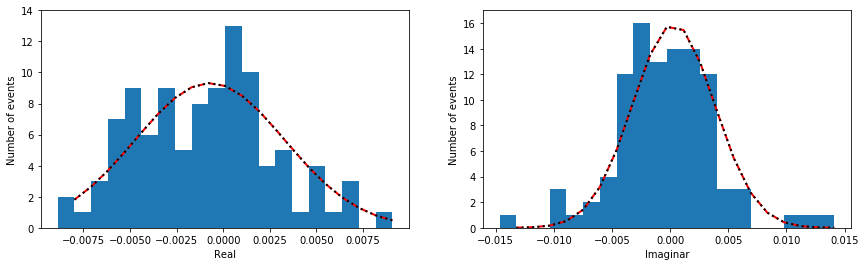

35 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00023941, 12.00000000, 0.00284328
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00005702, 9.77270062, 0.00300628
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00005702, 9.77267340, 0.00300629
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00071802, 15.00000000, 0.00409432
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00025922, 12.55814397, 0.00418691
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00025921, 12.55809350, 0.00418695


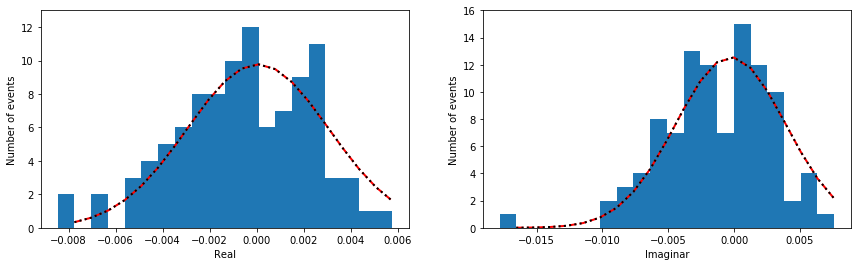

36 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00075937, 11.00000000, 0.01159481
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00011864, 9.35142168, 0.01212219
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00011863, 9.35144984, 0.01212211
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00022331, 11.00000000, 0.00277274
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00028549, 8.58026062, 0.00316462
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00028550, 8.58021712, 0.00316465


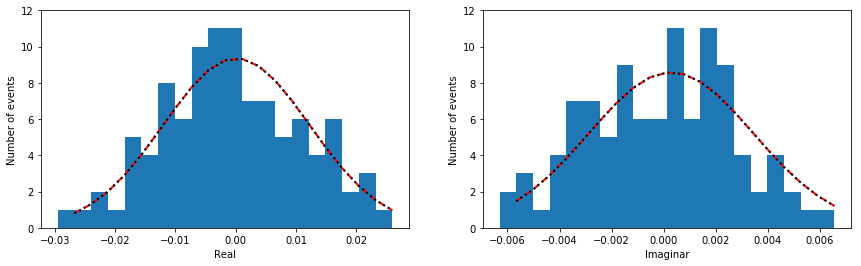

37 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00208238, 12.00000000, 0.02723168
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00386266, 7.95533650, 0.03210379
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00386268, 7.95534589, 0.03210370
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00010814, 19.00000000, 0.00893048
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00133602, 11.22377399, 0.00824230
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00133604, 11.22386168, 0.00824217


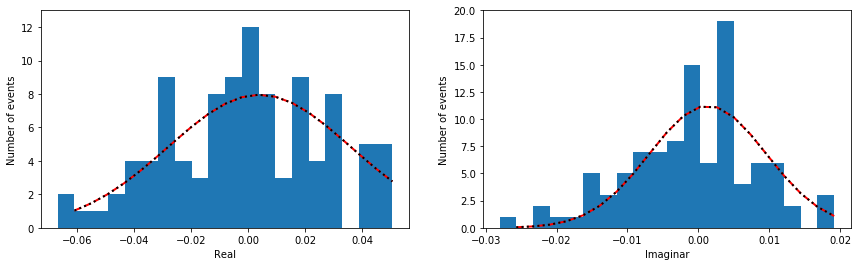

38 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00034941, 13.00000000, 0.00558985
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00012859, 9.48145351, 0.00573083
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00012858, 9.48150587, 0.00573077
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00011418, 11.00000000, 0.00130884
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00015710, 8.44535430, 0.00148520
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00015710, 8.44533847, 0.00148521


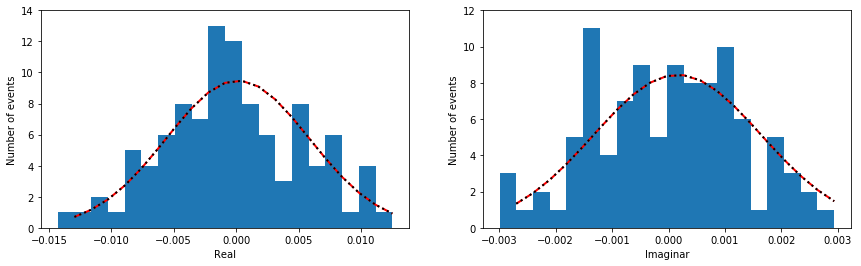

39 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00017789, 12.00000000, 0.00251678
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00016652, 10.77650109, 0.00256911
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00016652, 10.77649496, 0.00256912
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00015077, 13.00000000, 0.00328610
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00006079, 9.78889776, 0.00303081
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00006080, 9.78910117, 0.00303069


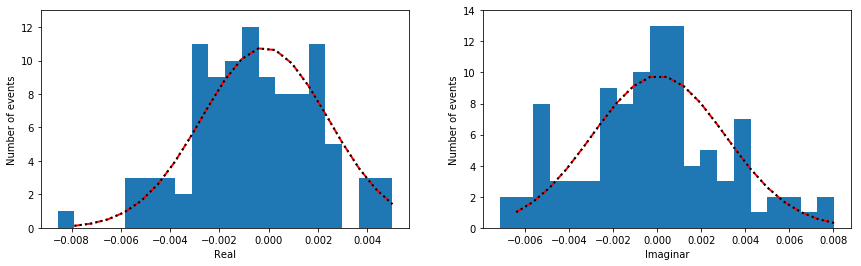

40 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00098872, 15.00000000, 0.00885965
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00008887, 11.86927166, 0.00795656
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00008886, 11.86935306, 0.00795645
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00094432, 15.00000000, 0.01185101
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00054691, 11.12623378, 0.01177969
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00054691, 11.12622012, 0.01177972


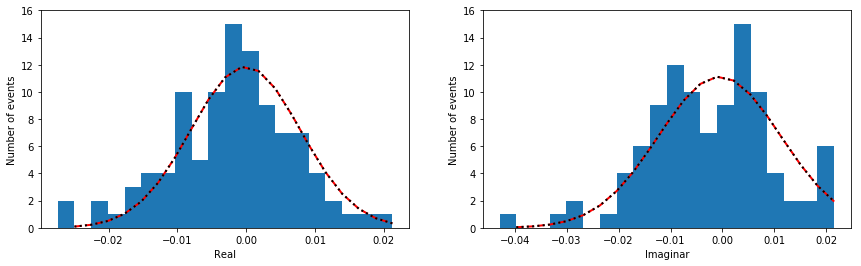

41 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00127229, 16.00000000, 0.07360541
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00355667, 10.48298978, 0.07576801
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00355667, 10.48298496, 0.07576808
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00650887, 15.00000000, 0.10595778
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00432641, 13.98286330, 0.08636072
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00432644, 13.98286648, 0.08636068


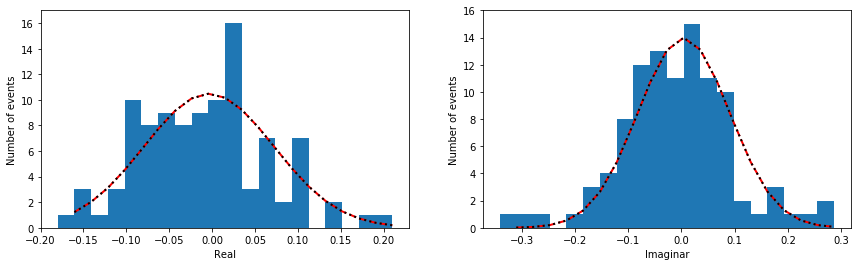

42 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00048135, 16.00000000, 0.00791138
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00019976, 9.63318867, 0.00831449
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00019979, 9.63317385, -0.00831452
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00027465, 16.00000000, 0.00610873
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00050713, 9.79716430, 0.00635870
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00050712, 9.79716653, -0.00635869


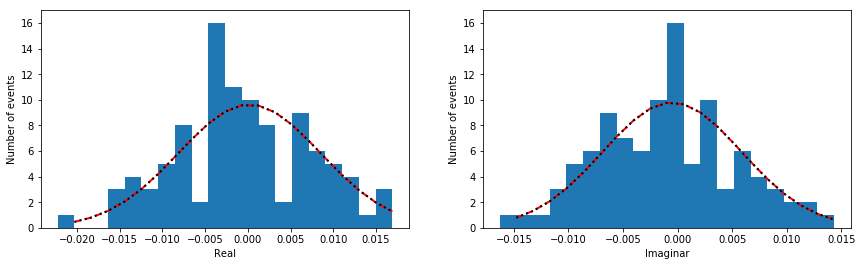

43 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00027982, 12.00000000, 0.00433136
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00008158, 9.75035591, 0.00458681
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00008159, 9.75037389, 0.00458679
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00023461, 13.00000000, 0.00490598
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00067485, 9.66931667, 0.00502760
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00067485, 9.66932113, 0.00502759


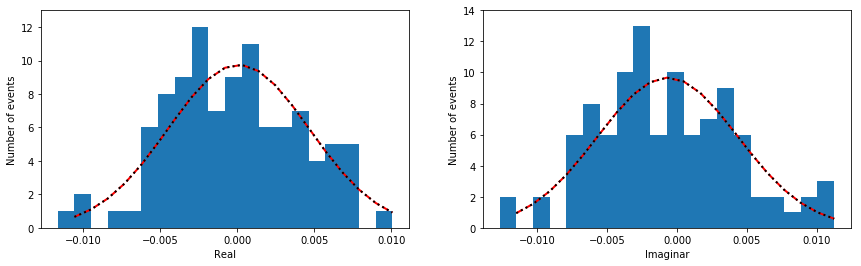

44 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00000018, 16.00000000, 0.00113328
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00001383, 10.00838204, 0.00110679
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00001383, 10.00845328, 0.00110677
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00002367, 13.00000000, 0.00168876
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00000865, 11.69213462, 0.00162624
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00000865, 11.69214075, 0.00162623


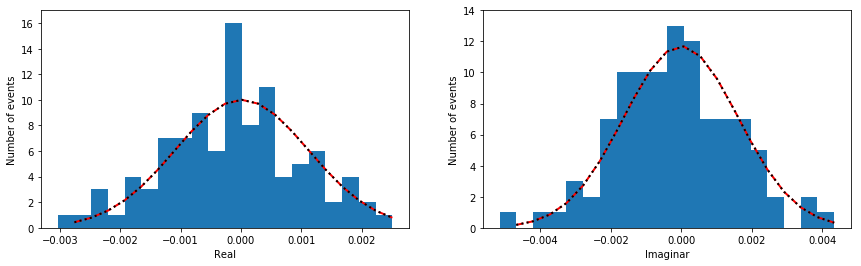

45 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00007870, 14.00000000, 0.00978851
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00095994, 9.56540493, 0.00908517
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00095998, 9.56556993, 0.00908486
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00114642, 16.00000000, 0.01127421
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00169513, 12.52515678, 0.00995851
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00169515, 12.52537405, -0.00995816


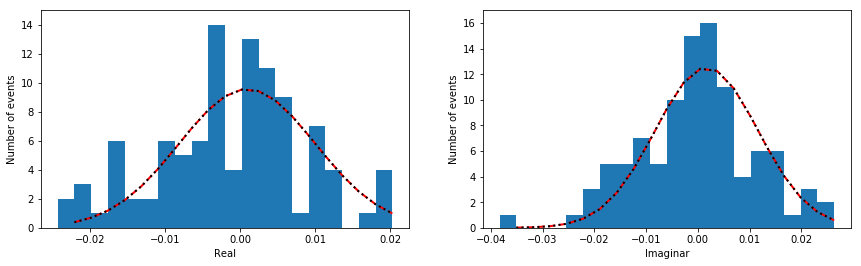

46 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00001703, 22.00000000, 0.00253116
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00031818, 14.23506366, 0.00205479
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00031819, 14.23526520, -0.00205474
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00015766, 14.00000000, 0.00357023
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00007410, 10.74341902, 0.00342399
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00007410, 10.74349307, 0.00342394


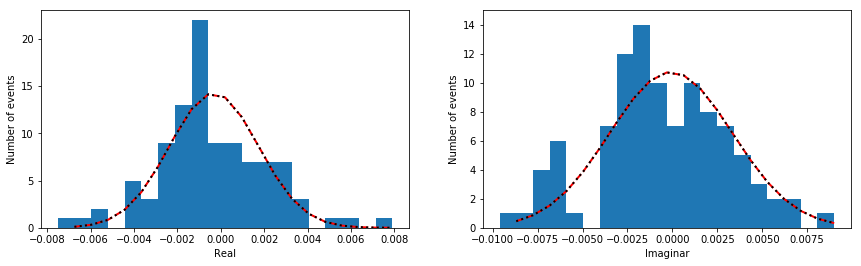

47 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00052077, 11.00000000, 0.00772649
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00004402, 9.23700708, 0.00896090
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00004401, 9.23696200, 0.00896099
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00128848, 14.00000000, 0.01327045
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00115374, 10.34593411, 0.01328822
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00115374, 10.34595223, 0.01328818


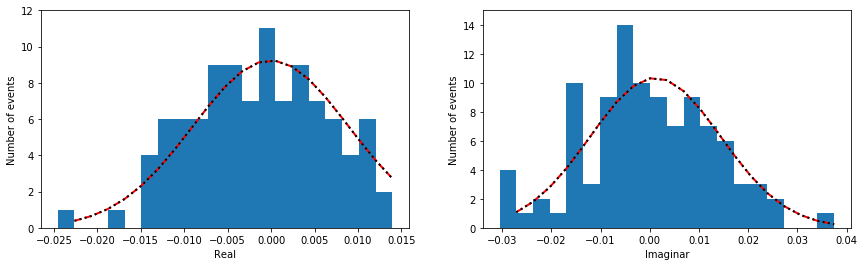

48 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00001532, 16.00000000, 0.00721550
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00008718, 13.23188388, 0.00616822
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00008718, 13.23200823, -0.00616810
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00015584, 12.00000000, 0.00570119
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00086883, 9.20864801, 0.00572512
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00086884, 9.20872864, 0.00572502


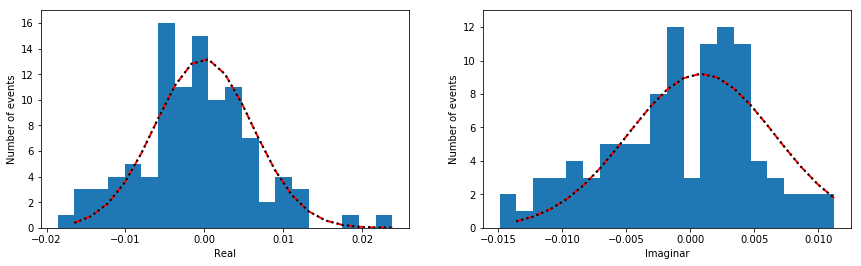

49 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00003168, 13.00000000, 0.00421314
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00017873, 8.77819343, 0.00479692
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00017873, 8.77817965, 0.00479694
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00067052, 13.00000000, 0.00469233
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00025070, 11.65869769, 0.00481810
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00025069, 11.65865745, 0.00481813


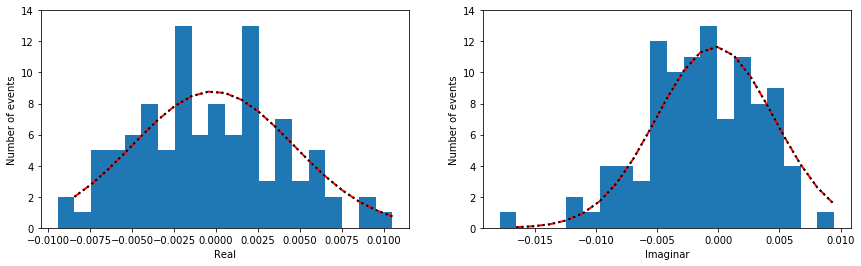

50 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00016568, 11.00000000, 0.00109811
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00032070, 6.88722364, 0.00151754
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00032071, 6.88721850, 0.00151754
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00017738, 15.00000000, 0.00150299
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00021654, 12.32171650, 0.00157271
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00021654, 12.32166412, 0.00157273


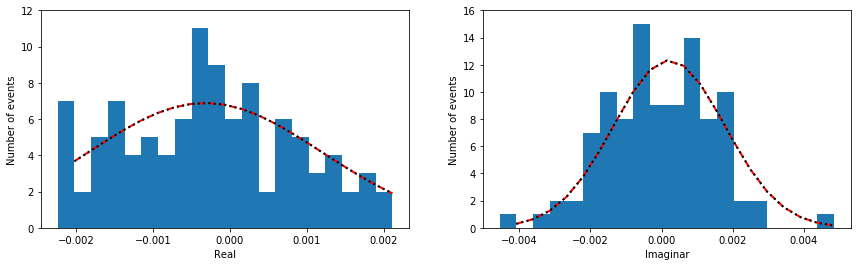

51 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00026427, 15.00000000, 0.00817519
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00021750, 12.12737021, 0.00735194
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00021749, 12.12744371, 0.00735185
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00014242, 15.00000000, 0.01205086
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00032785, 10.98764082, 0.01142383
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00032785, 10.98771234, 0.01142369


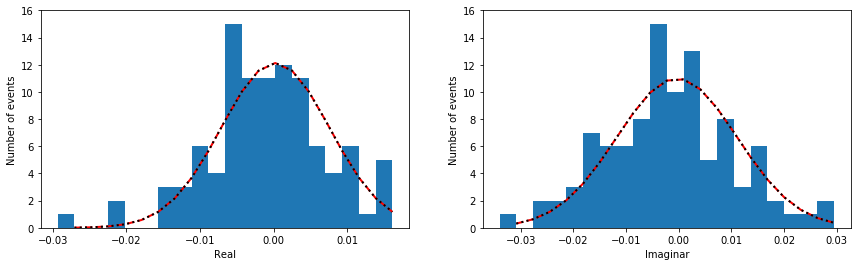

52 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00029637, 15.00000000, 0.00359547
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00036599, 11.32995791, 0.00361991
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00036599, 11.32999299, 0.00361988
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00043208, 16.00000000, 0.00250735
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00043988, 13.66817063, 0.00208830
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00043988, 13.66836038, -0.00208825


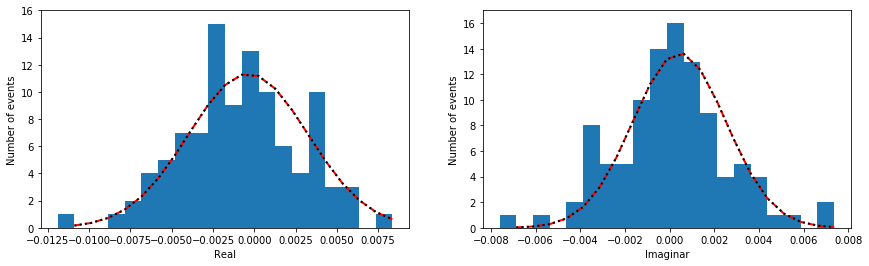

53 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00009311, 11.00000000, 0.00242153
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00030562, 8.14349209, 0.00286932
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00030562, 8.14348199, 0.00286933
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00034154, 11.00000000, 0.00328895
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00012622, 10.10498233, 0.00359924
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00012622, 10.10497005, 0.00359925


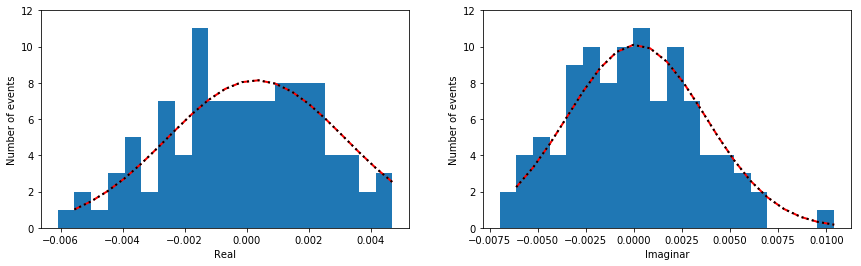

54 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00046966, 13.00000000, 0.00805258
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00000252, 8.39200307, 0.00878063
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00000249, 8.39201131, 0.00878061
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00073911, 14.00000000, 0.01277943
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00022152, 8.40818310, 0.01388651
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00022155, 8.40819826, 0.01388646


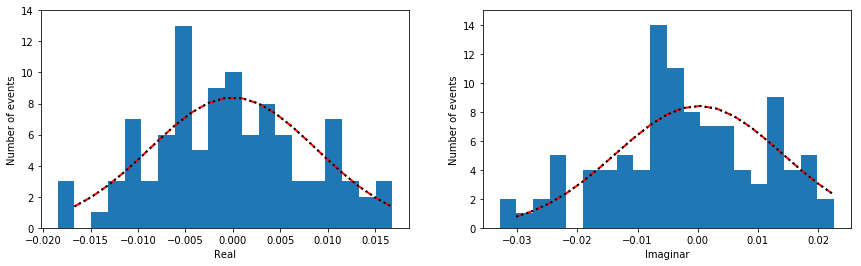

55 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00001270, 12.00000000, 0.00121354
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00009488, 9.67402201, 0.00127661
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00009488, 9.67403862, 0.00127661
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00029331, 12.00000000, 0.00164366
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00028067, 9.80037113, 0.00182699
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00028068, 9.80042627, 0.00182697


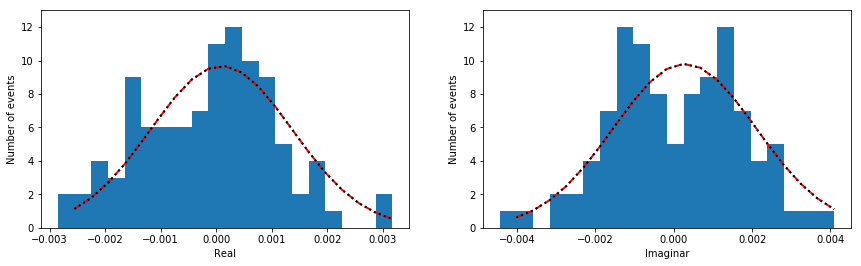

56 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00005807, 12.00000000, 0.00283939
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00034087, 9.51942625, 0.00297714
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00034087, 9.51946674, 0.00297711
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00007208, 13.00000000, 0.00490817
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00002353, 11.64394223, 0.00487952
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00002353, 11.64392920, 0.00487953


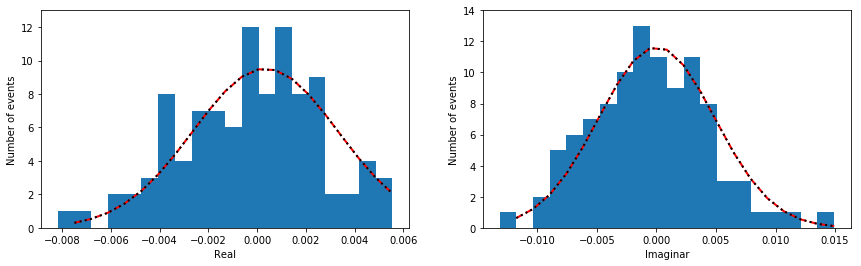

57 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00107555, 15.00000000, 0.02368608
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00132021, 10.37070129, 0.02452581
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00132024, 10.37069746, 0.02452583
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00139904, 12.00000000, 0.01835830
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00219726, 9.14983596, 0.02134241
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00219726, 9.14980856, 0.02134254


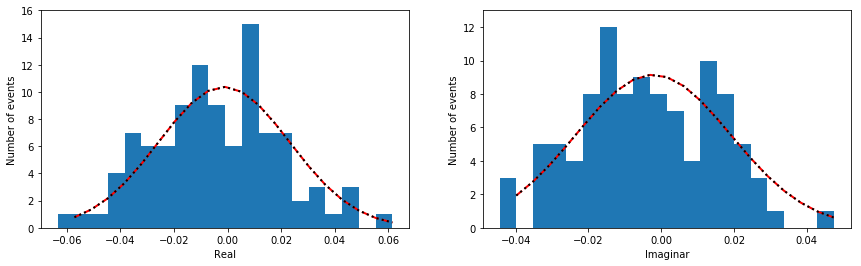

58 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00005524, 12.00000000, 0.00351155
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00075528, 7.53149658, 0.00432736
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00075526, 7.53150195, 0.00432735
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00044414, 15.00000000, 0.00379109
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00063886, 10.36111569, 0.00362456
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00063885, 10.36115134, 0.00362453


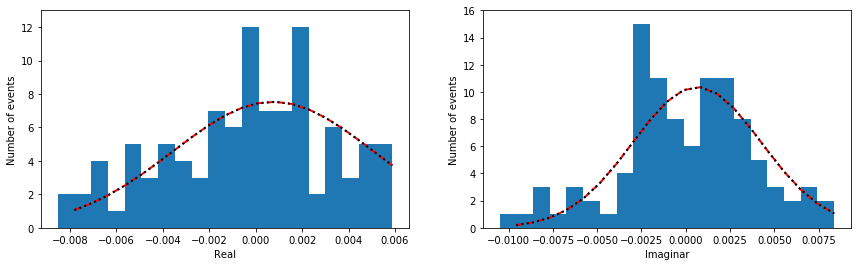

59 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.11886701, 18.00000000, 1.06099573
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.14888751, 10.66905271, 1.02713829
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.14889171, 10.66915127, -1.02711926
 Calc Values (np):  [mean, amp, standardDeviation] = -0.04592144, 12.00000000, 1.48534308
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00584945, 8.04299982, 1.64340127
 Curve fit (MLE):   [mean, amp, standardDeviation] = nan, nan, nan


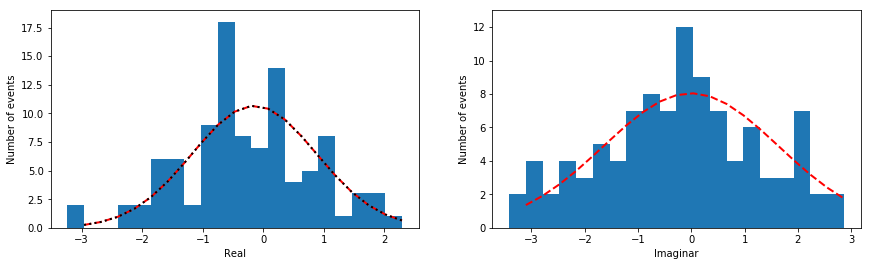

60 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00014109, 12.00000000, 0.00234030
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00002948, 10.30702217, 0.00244148
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00002948, 10.30702878, 0.00244148
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00037208, 11.00000000, 0.00252428
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00041797, 9.46505520, 0.00270592
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00041797, 9.46504672, 0.00270593


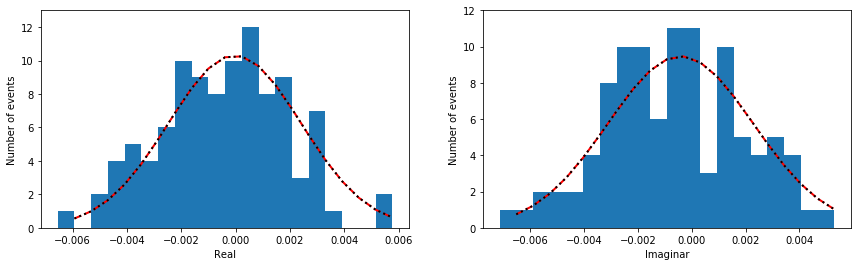

61 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00258008, 13.00000000, 0.04008413
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00392693, 8.89139345, 0.04168992
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00392693, 8.89141448, 0.04168972
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00122365, 12.00000000, 0.04983629
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00401682, 9.72540922, 0.04951005
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00401722, 9.72555271, 0.04950858


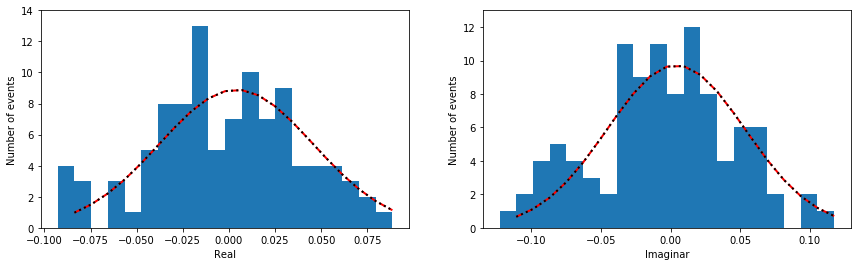

62 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00005344, 15.00000000, 0.00358561
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00054169, 8.82127005, 0.00413433
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00054170, 8.82125514, 0.00413434
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00064233, 11.00000000, 0.00455931
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00109928, 10.36357818, 0.00445236
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00109929, 10.36359121, 0.00445235


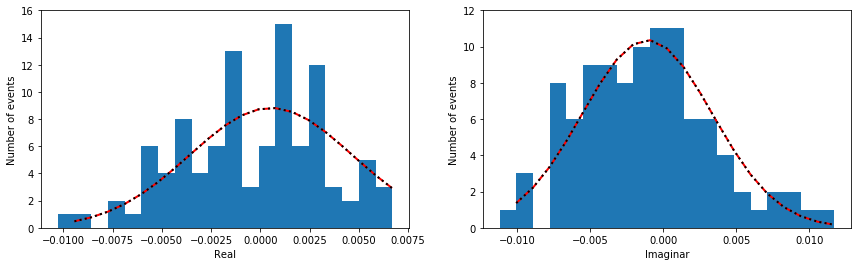

63 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00204812, 15.00000000, 0.02540831
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00035919, 12.29012039, 0.02416557
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00035910, 12.29015716, 0.02416542
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00028731, 11.00000000, 0.01756637
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00143593, 8.64678290, 0.01902886
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00143595, 8.64677763, 0.01902889


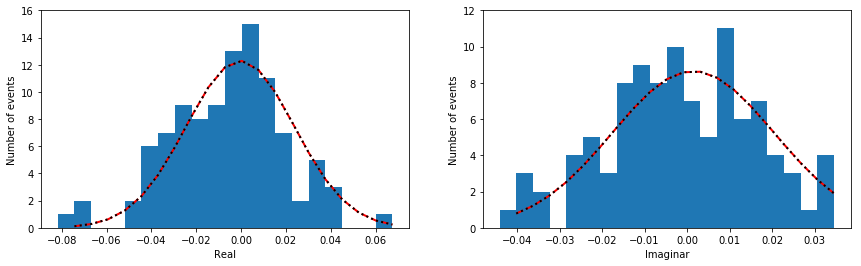

64 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00021895, 15.00000000, 0.00372280
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00029133, 11.06686644, 0.00328919
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00029131, 11.06701241, 0.00328910
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00024755, 14.00000000, 0.00428068
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00016848, 11.29729525, 0.00369956
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00016848, 11.29755737, 0.00369939


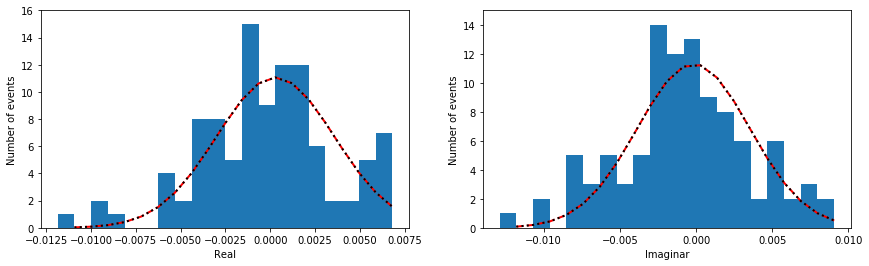

65 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00021033, 13.00000000, 0.00245952
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00004835, 8.64977831, 0.00273769
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00004836, 8.64978555, 0.00273768
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00015946, 12.00000000, 0.00281779
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00029793, 8.77510713, 0.00319350
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00029793, 8.77509132, 0.00319351


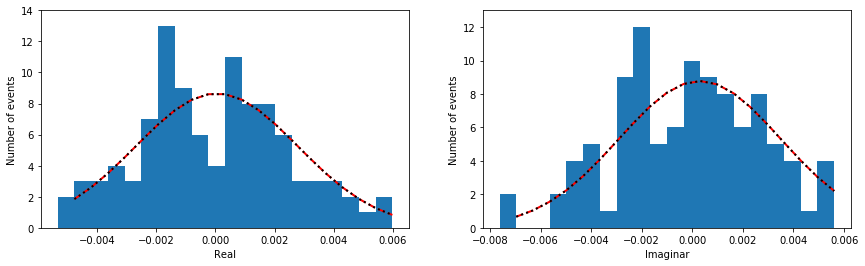

66 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00118190, 12.00000000, 0.04279973
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00111426, 9.76741323, 0.04295255
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00111439, 9.76749926, 0.04295179
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00072814, 12.00000000, 0.05334356
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00011135, 10.58457333, 0.05283201
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00011146, 10.58461068, 0.05283164


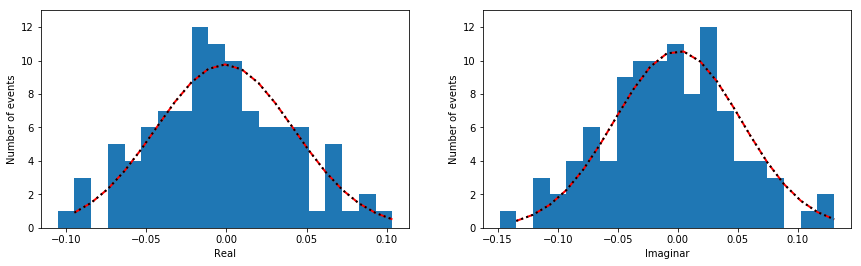

67 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00006803, 13.00000000, 0.00724014
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00066920, 11.35301997, 0.00674626
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00066922, 11.35307275, 0.00674620
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00071579, 10.00000000, 0.00825996
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00040052, 9.11949985, 0.00872122
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00040053, 9.11950835, 0.00872120


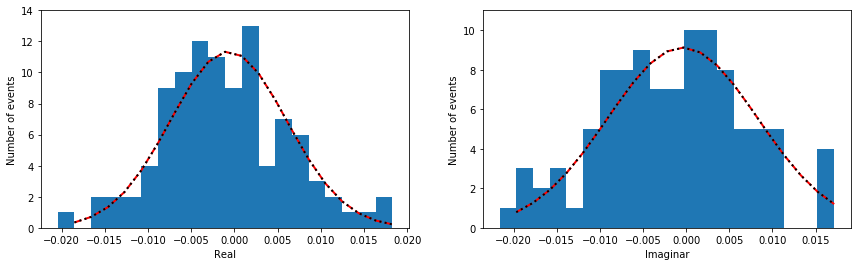

68 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00176011, 13.00000000, 0.01036304
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00250580, 11.11692196, 0.01002888
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00250582, 11.11695129, 0.01002883
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00076586, 13.00000000, 0.01293581
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00090137, 11.31609980, 0.01285822
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00090137, 11.31609025, 0.01285824


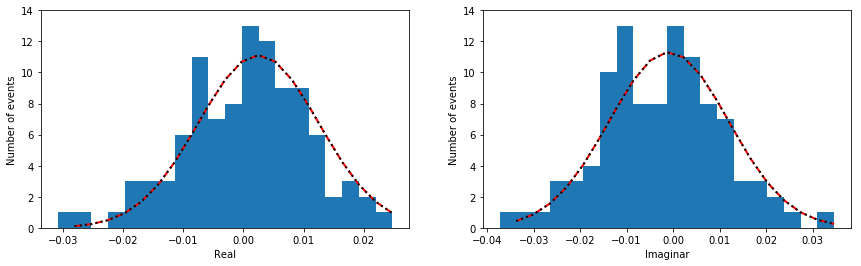

69 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00043753, 12.00000000, 0.02600659
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00117132, 8.41960292, 0.02935221
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00117131, 8.41959364, 0.02935228
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00013218, 13.00000000, 0.03147615
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00293303, 12.75890709, 0.02811824
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00293304, 12.75894339, 0.02811808


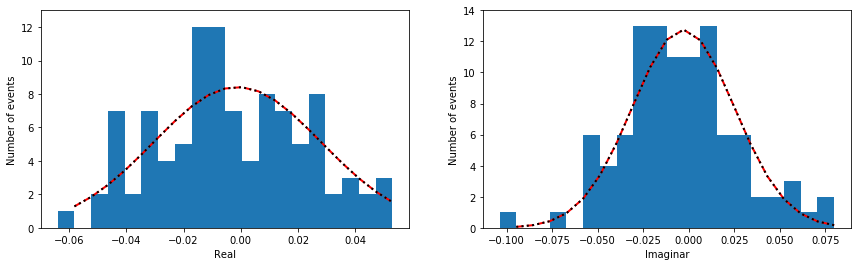

70 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00000274, 15.00000000, 0.00522643
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00034183, 12.10084195, 0.00489788
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00034185, 12.10091887, 0.00489782
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00026982, 13.00000000, 0.00615858
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00097522, 10.16570533, 0.00571736
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00097524, 10.16584022, 0.00571720


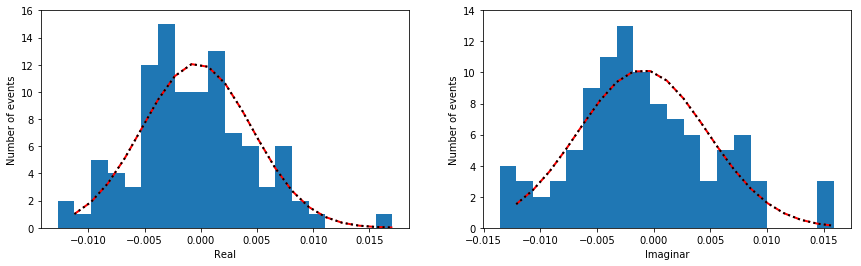

71 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00672048, 13.00000000, 0.05110008
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00580431, 11.04099071, 0.05288073
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00580432, 11.04097739, 0.05288085
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00598285, 14.00000000, 0.06234980
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.01077118, 9.59934956, 0.06265186
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.01077156, 9.59944871, 0.06265055


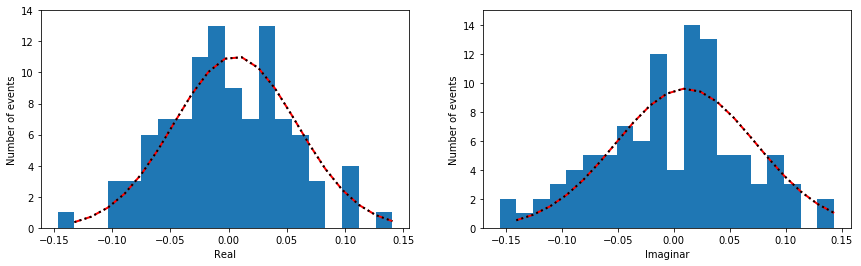

72 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00292385, 14.00000000, 0.02798902
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00105795, 10.46430845, 0.02977518
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00105792, 10.46426049, 0.02977546
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00172370, 14.00000000, 0.03877436
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00127192, 11.66789896, 0.03524053
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00127197, 11.66799468, 0.03523995


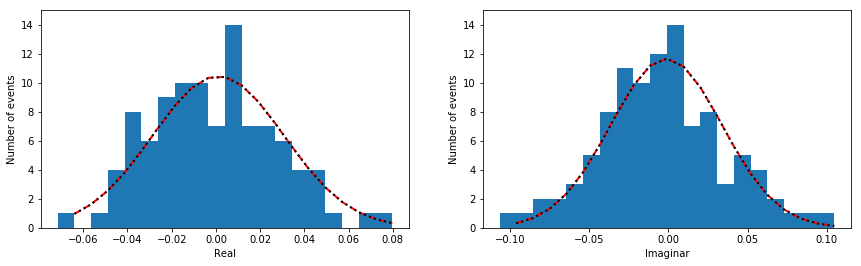

73 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00485216, 13.00000000, 0.05479249
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00460432, 11.58905781, 0.05273449
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00460433, 11.58907765, 0.05273431
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00570608, 14.00000000, 0.07188086
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00241607, 11.97449201, 0.06098797
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00241589, 11.97459671, 0.06098691


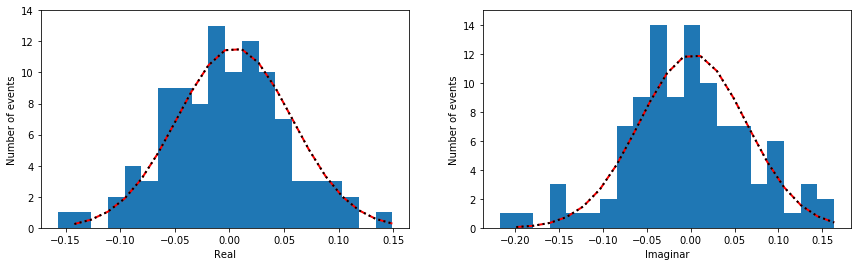

74 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00095969, 16.00000000, 0.00571623
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00161589, 11.69318864, 0.00605796
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00161590, 11.69316166, 0.00605799
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00000212, 10.00000000, 0.00852489
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00104870, 7.98273361, 0.01019240
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00104869, 7.98273111, 0.01019241


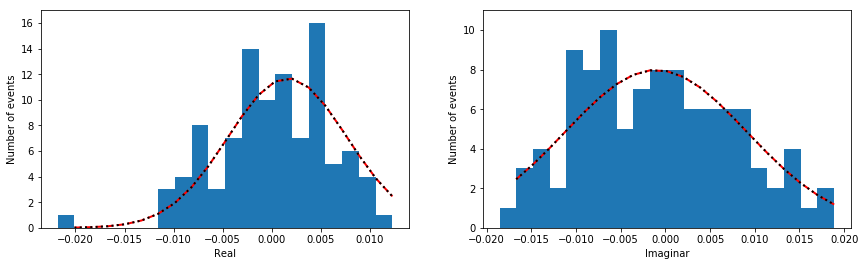

75 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00558961, 10.00000000, 0.08361898
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00449070, 8.55656111, 0.09203197
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00449082, 8.55656041, 0.09203198
 Calc Values (np):  [mean, amp, standardDeviation] = -0.01421178, 16.00000000, 0.13186095
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00791482, 12.14063258, 0.11988707
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00791465, 12.14070178, 0.11988570


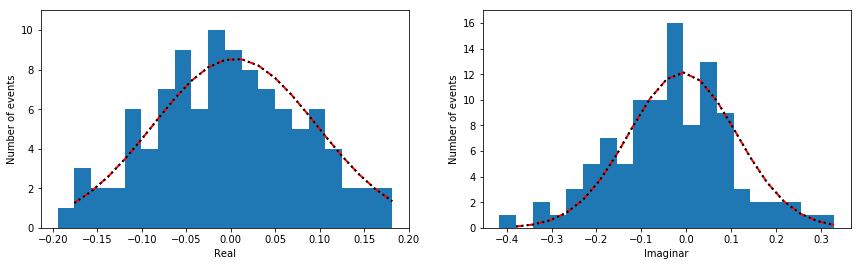

76 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00117912, 17.00000000, 0.09864129
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00543746, 9.87669904, 0.10102048
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00543746, 9.87673874, -0.10101965
 Calc Values (np):  [mean, amp, standardDeviation] = -0.01514920, 11.00000000, 0.08626230
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.01918098, 9.58877377, 0.08331868
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.01918105, 9.58882089, 0.08331785


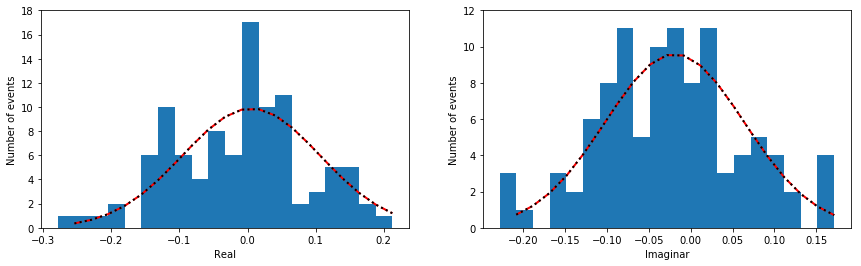

77 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00000291, 14.00000000, 0.00971133
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00018152, 10.52555935, 0.00903253
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00018153, 10.52565612, 0.00903236
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00173421, 13.00000000, 0.01408868
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00413208, 8.38838241, 0.01508406
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00413203, 8.38842253, 0.01508390


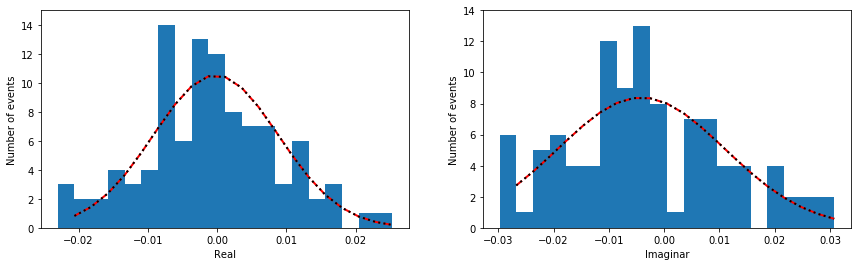

78 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00021648, 17.00000000, 0.00588020
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00001677, 11.93477098, 0.00525849
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00001678, 11.93488616, 0.00525839
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00053970, 16.00000000, 0.00870557
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00179558, 12.59344884, 0.00777759
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00179558, 12.59349392, 0.00777754


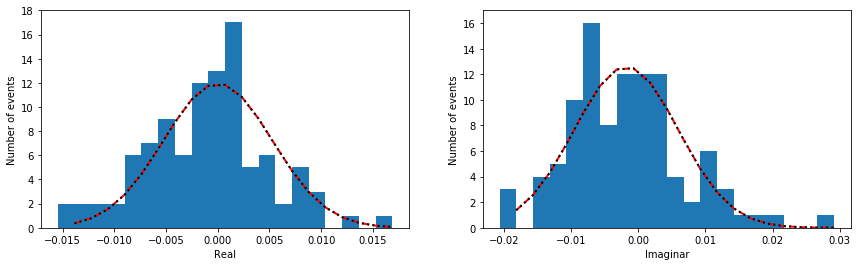

79 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00060866, 13.00000000, 0.00992659
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00159404, 9.90929851, 0.01015195
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00159407, 9.90932891, 0.01015189
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00031301, 15.00000000, 0.01356725
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00133585, 11.33524002, 0.01432684
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00133583, 11.33520645, 0.01432693


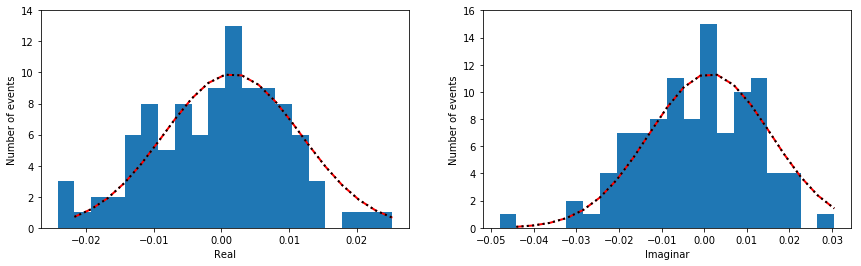

80 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00213486, 13.00000000, 0.01712868
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00098245, 11.17974188, 0.01571595
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00098237, 11.17984102, 0.01571567
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00145276, 15.00000000, 0.02183573
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00140694, 11.31693063, 0.01930683
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00140693, 11.31703516, -0.01930647


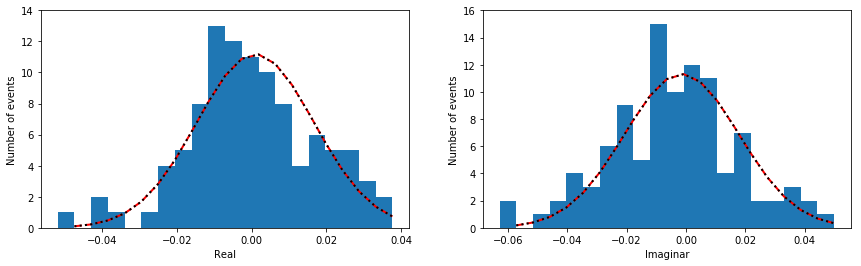

81 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00700635, 15.00000000, 0.25590027
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.01259373, 10.03401339, 0.24659727
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.01259404, 10.03403689, -0.24659610
 Calc Values (np):  [mean, amp, standardDeviation] = -0.02853716, 15.00000000, 0.36496333
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.02428288, 10.87963495, 0.34206876
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.02428275, 10.87969775, -0.34206480


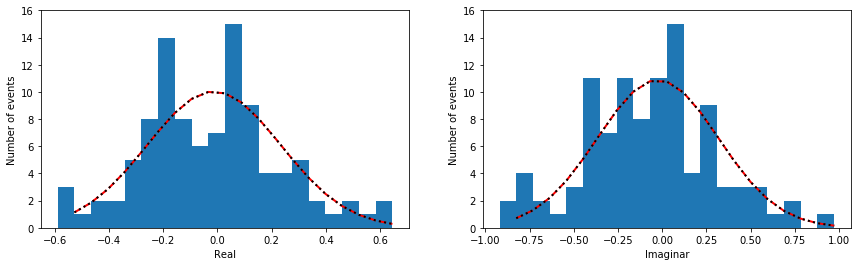

82 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.08087417, 13.00000000, 0.44134425
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.10166567, 10.50061197, 0.40288096
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.10166490, 10.50071030, -0.40287335
 Calc Values (np):  [mean, amp, standardDeviation] = 0.01985873, 16.00000000, 0.34852161
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00335691, 13.81277574, 0.30112258
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00335760, 13.81298088, 0.30111364


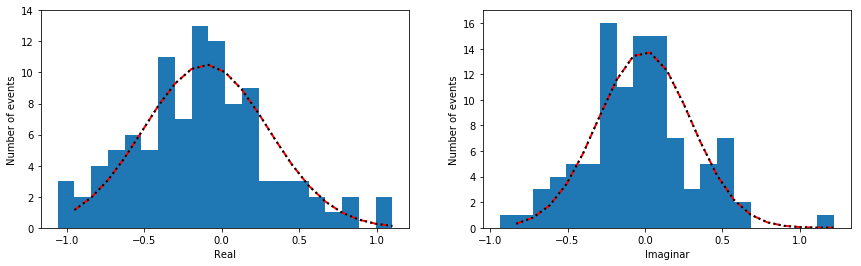

83 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00149253, 11.00000000, 0.01159320
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00238076, 9.14035180, 0.01283745
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00238075, 9.14035263, 0.01283745
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00120802, 11.00000000, 0.01150936
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00175543, 7.85372412, 0.01378906
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00175543, 7.85370969, 0.01378912


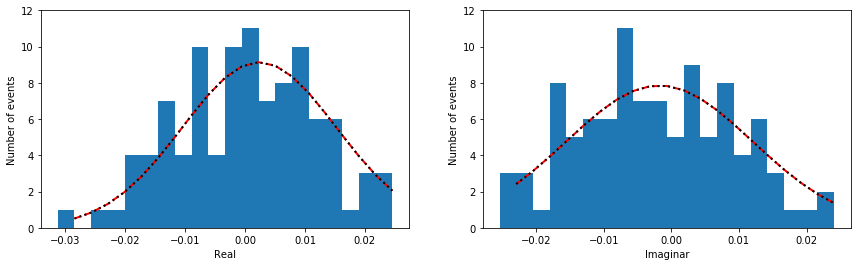

84 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00181278, 17.00000000, 0.05169017
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00615678, 12.89658937, 0.03808949
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00615723, 12.89691886, 0.03808754
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00182420, 14.00000000, 0.05104617
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00173913, 12.82535482, 0.04871266
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00173912, 12.82540464, 0.04871228


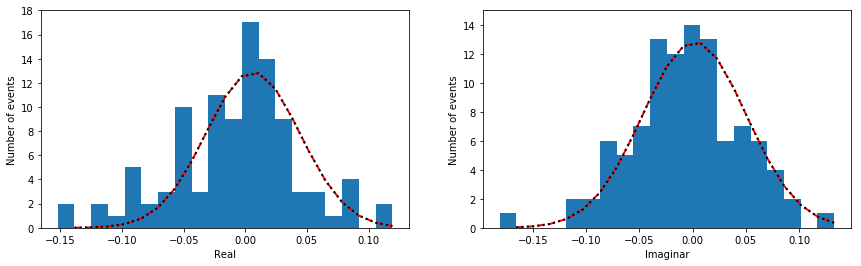

85 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00276974, 13.00000000, 0.01852523
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00066917, 10.59766877, 0.01944727
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00066903, 10.59769006, 0.01944719
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00051785, 14.00000000, 0.02211351
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00031340, 9.84437088, 0.02223153
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00031337, 9.84439546, 0.02223142


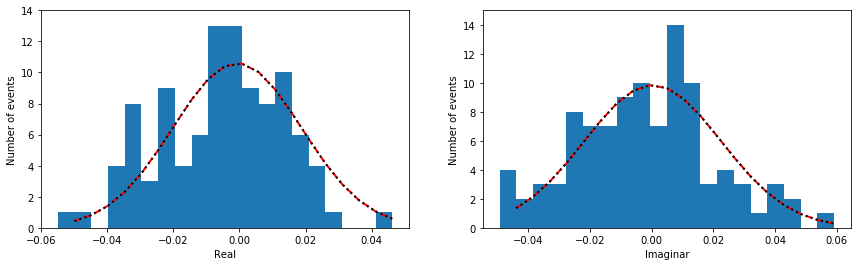

86 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.05514241, 10.00000000, 0.50611343
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.01084133, 6.60212578, 0.73950996
 Curve fit (MLE):   [mean, amp, standardDeviation] = nan, nan, nan
 Calc Values (np):  [mean, amp, standardDeviation] = 0.04002628, 11.00000000, 0.39241902
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00001945, 7.89967534, 0.45244586
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00001740, 7.89968070, -0.45244517


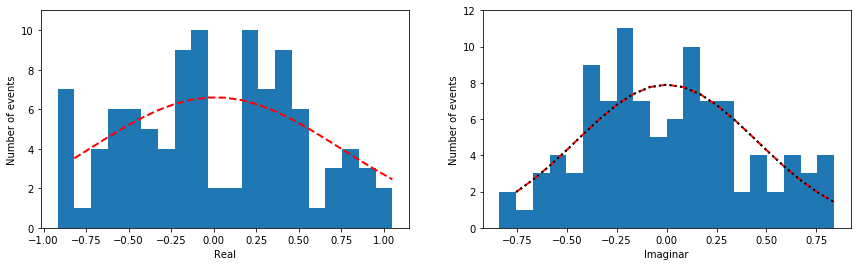

87 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.03207661, 14.00000000, 0.29358770
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.02505986, 10.60718169, 0.30608225
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.02505941, 10.60713911, -0.30608480
 Calc Values (np):  [mean, amp, standardDeviation] = 0.08923541, 13.00000000, 0.43140611
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.04063539, 9.58150588, 0.46533373
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.04063660, 9.58153155, -0.46533118


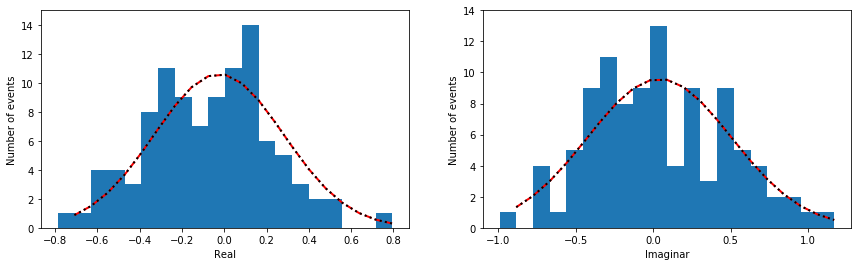

88 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.05320727, 13.00000000, 1.24678306
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.03030783, 12.53165343, 1.13070705
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.03030785, 12.53167424, 1.13070334
 Calc Values (np):  [mean, amp, standardDeviation] = -0.24504210, 15.00000000, 1.17425680
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.10163129, 12.86724337, 0.98877966
 Curve fit (MLE):   [mean, amp, standardDeviation] = nan, nan, nan


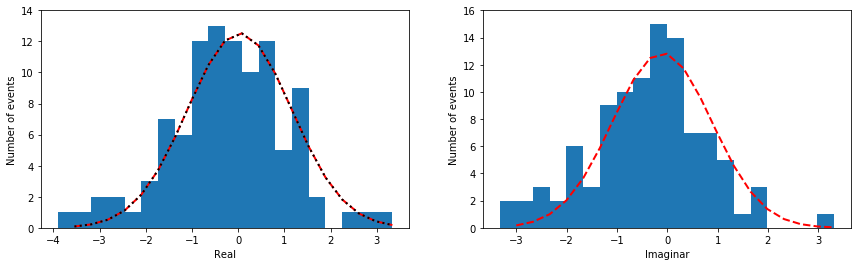

89 0
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00367538, 16.00000000, 0.07945406
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00013916, 10.75115668, 0.08486011
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00014001, 10.75118248, 0.08485970
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00731075, 15.00000000, 0.11921385
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.01781265, 11.03244679, 0.10829855
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.01781315, 11.03269297, 0.10829370


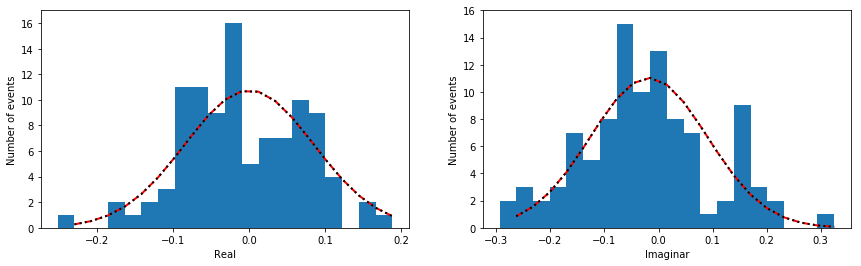

90 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.15323844, 12.00000000, 2.27675810
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.26233333, 8.64182330, 2.49292843
 Curve fit (MLE):   [mean, amp, standardDeviation] = nan, nan, nan
 Calc Values (np):  [mean, amp, standardDeviation] = -0.03265340, 15.00000000, 1.41409125
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.02721868, 12.77853304, 1.36019792
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.02721838, 12.77856526, -1.36019094


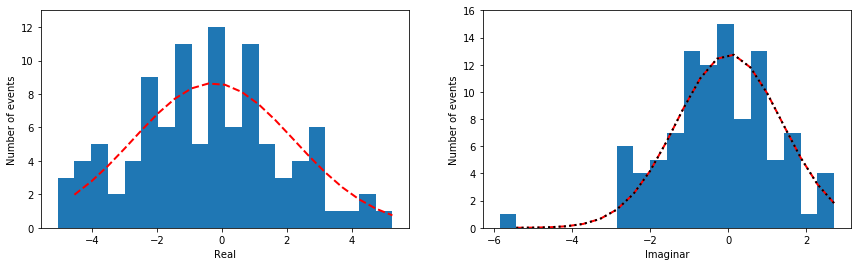

91 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00064330, 14.00000000, 0.01767107
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.00000139, 8.98413362, 0.01777210
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.00000138, 8.98420983, 0.01777179
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00073074, 11.00000000, 0.01706812
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.00252214, 8.76173297, 0.01929650
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.00252214, 8.76174617, 0.01929643


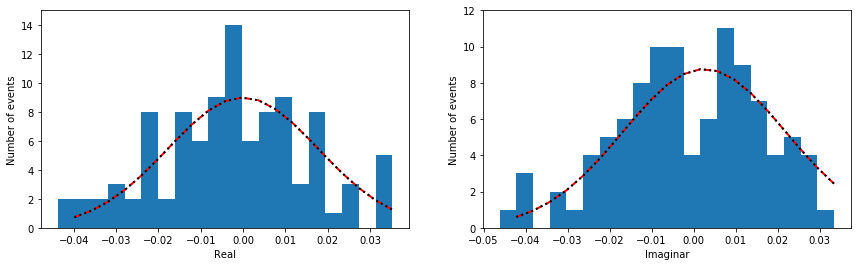

92 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.00491140, 14.00000000, 0.21823402
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.02694688, 11.03148916, 0.20057424
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.02694709, 11.03154191, 0.20057231
 Calc Values (np):  [mean, amp, standardDeviation] = 0.05667070, 12.00000000, 0.24473486
 Curve fit (Gauss): [mean, amp, standardDeviation] = 0.07104376, 9.29821044, 0.25302463
 Curve fit (MLE):   [mean, amp, standardDeviation] = 0.07104291, 9.29820995, 0.25302465


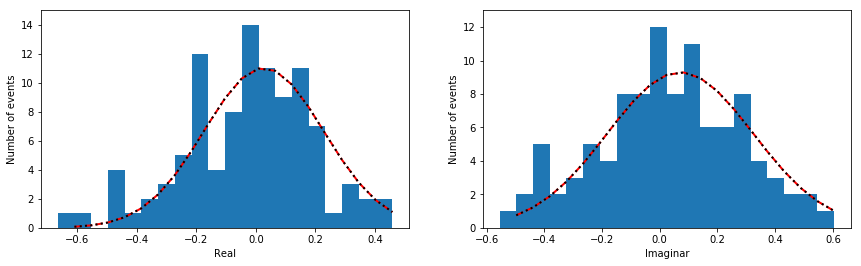

93 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.32478404, 16.00000000, 1.62006305
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.37701431, 12.77516573, 1.57110493
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.37701522, 12.77518187, -1.57110100
 Calc Values (np):  [mean, amp, standardDeviation] = 0.00927291, 11.00000000, 1.60645548
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.17079672, 8.51693659, 1.83440933
 Curve fit (MLE):   [mean, amp, standardDeviation] = nan, nan, nan


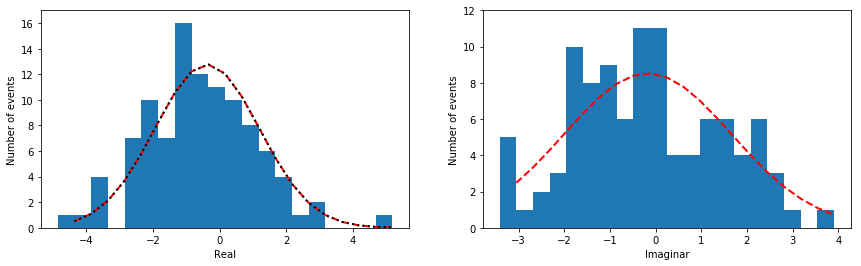

94 0
 Calc Values (np):  [mean, amp, standardDeviation] = -0.04182015, 13.00000000, 0.19672449
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.02844411, 9.51368671, 0.20388576
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.02844149, 9.51380975, -0.20388037
 Calc Values (np):  [mean, amp, standardDeviation] = -0.02449478, 13.00000000, 0.27017321
 Curve fit (Gauss): [mean, amp, standardDeviation] = -0.03133449, 10.38272409, 0.27921813
 Curve fit (MLE):   [mean, amp, standardDeviation] = -0.03133447, 10.38272753, -0.27921794


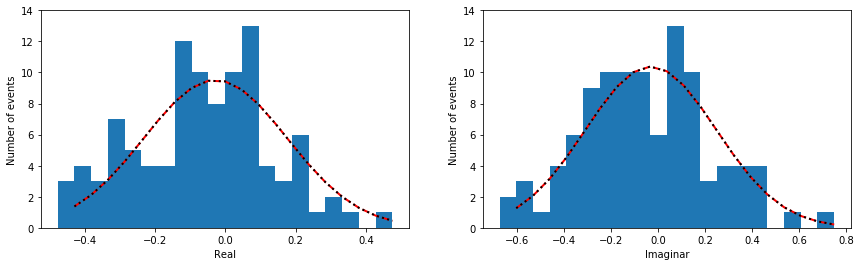

In [12]:
nmbWaves = 95 # Remove for last run
resultMatrixes = np.empty([nmbWaves, nmbWaves], dtype=list)
matrixReal = np.empty(nmbFolder, dtype=float)
matrixImag = np.empty(nmbFolder, dtype=float)
problemValues = []
errorMsg = "\n\nERROR:"
plot = False

#bar = progressbar.ProgressBar(maxval=nmbWaves, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
#bar.start()
for waveIndexI in range(0,nmbWaves): 
    #bar.update(waveIndexI + 1)
    for waveIndexJ in range(0,waveIndexI+1):
        print waveIndexI, waveIndexJ
        logging.info("%s, %s" %(waveIndexI, waveIndexJ))
        resultVec={'real': {'poptNP':'', 'chiSquaredGauss': '', 'chiSquaredMLE': '', 'popt': '', 'poptMLE': ''}, 'imag': {'poptNP':'','chiSquaredGauss': '', 'chiSquaredMLE': '', 'popt': '', 'poptMLE': ''}}
    
        element = vecMatrix[waveIndexI][waveIndexJ]
        for i in range(0,nmbFolder):
            matrixReal[i] = element[i].real
            matrixImag[i] = element[i].imag

        if plot:
            plt.figure(1)
            plt.subplots_adjust(right=2)
            plt.subplot(121)
        result = createPlot(matrixReal, "Real", nmbFolder, plt, plot, waveIndexI, waveIndexJ, errorMsg)
        resultVec['real'] = {'poptNP':result[0],'chiSquaredGauss': result[1], 'chiSquaredMLE': result[2], 'popt': result[3], 'poptMLE': result[4]}
        errorMsg = result[4]
        if result[0][1] >= 1 or result[1][1] >= 1 or math.isnan(result[0][1]) or math.isnan(result[1][1]):
            problemValues.append({'waveIndexI': waveIndexI, 'waveIndexJ': waveIndexJ, 'type':'real', 'poptNP': result[0], 'chiSquaredGauss': result[1], 'chiSquaredMLE': result[2], 'popt': result[3], 'poptMLE': result[4]})
            errorMsg = "%s\n%i, %i: Error to calc real Value" %(errorMsg, waveIndexI, waveIndexJ)
            
            
        if waveIndexI != waveIndexJ:
            #print ""
            if plot:
                plt.subplot(122)
            result = createPlot(matrixImag, "Imaginar", nmbFolder, plt ,plot, waveIndexI, waveIndexJ, errorMsg)
            resultVec['imag'] = {'poptNP':result[0], 'chiSquaredGauss': result[1], 'chiSquaredMLE': result[2], 'popt': result[3], 'poptMLE': result[4]}
            errorMsg = result[4]
            if result[0][1] >= 1 or result[1][1] >= 1 or math.isnan(result[0][1]) or math.isnan(result[1][1]):
                problemValues.append({'waveIndexI': waveIndexI, 'waveIndexJ': waveIndexJ, 'type':'imag', 'poptNP': result[0], 'chiSquaredGauss': result[1], 'chiSquaredMLE': result[2], 'popt': result[3], 'poptMLE': result[4]})
                errorMsg = "%s\n%i, %i: Error to calc imag Value" %(errorMsg, waveIndexI, waveIndexJ)
                
        resultMatrixes[waveIndexI][waveIndexJ] = resultVec
        resultMatrixes[waveIndexJ][waveIndexI] = resultVec
        if plot:
            plt.show()
logging.info(errorMsg)

In [ ]:
#print problemValues

In [ ]:
with open("CompareIntegraleWithVarianzWarning.txt", "w") as output:
    output.write(str(problemValues))
np.save('CompareIntegraleWithVarianzResult_50k', resultMatrixes)